**Assignment: Price Prediction: Surprise Housing**

Surprise Housing, a US-based firm that leverages data analytics to profitably flip real estate, is keen to penetrate the Australian market. They have assembled a dataset of Australian housing sales, encapsulated in the given CSV file, to aid their venture.

The task is to construct a regularized regression model with this data. The model will predict the actual value of potential properties, thereby guiding the company's investment decisions.

The core objectives of the problem are two-fold:

Identify which variables are significant in forecasting a house's price.
Determine the extent to which these significant variables can accurately predict a house's price.

In [103]:
import warnings
warnings.filterwarnings('ignore')

#Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV


#Dataset
train_data_set = pd.read_csv("train.csv", na_values="NAN")

train_data_set.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [104]:
#Shape of the data
train_data_set.shape

train_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [65]:
## DATA CLEANING


#Convert the data type of specific columns in the train_data_set


#Convert the data type of the columns 'MSSubClass', 'OverallQual', and 'OverallCond' to object:
train_data_set[['MSSubClass', 'OverallQual', 'OverallCond']] = train_data_set[['MSSubClass', 'OverallQual', 'OverallCond']].astype('object')

#Convert the data type of the columns 'LotFrontage' and 'MasVnrArea' to numeric (float64):
train_data_set[['LotFrontage', 'MasVnrArea']] = train_data_set[['LotFrontage', 'MasVnrArea']].astype('float64')

#To verify the data type conversion, you can check the data types of the five columns:
train_data_set[['MSSubClass', 'OverallQual', 'OverallCond', 'LotFrontage', 'MasVnrArea']].dtypes


MSSubClass      object
OverallQual     object
OverallCond     object
LotFrontage    float64
MasVnrArea     float64
dtype: object

In [66]:
#Calculate the percentage of missing values for each column.
total = train_data_set.isnull().sum().sort_values(ascending=False)
percent = (train_data_set.isnull().sum()/len(train_data_set)*100).sort_values(ascending=False)

#Concatenate the total number of missing values and their corresponding percentages.
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data.head(20)

Total    Percent
PoolQC         1453  99.520548
MiscFeature    1406  96.301370
Alley          1369  93.767123
Fence          1179  80.753425
FireplaceQu     690  47.260274
LotFrontage     259  17.739726
GarageYrBlt      81   5.547945
GarageCond       81   5.547945
GarageType       81   5.547945
GarageFinish     81   5.547945
GarageQual       81   5.547945
BsmtFinType2     38   2.602740
BsmtExposure     38   2.602740
BsmtQual         37   2.534247
BsmtCond         37   2.534247
BsmtFinType1     37   2.534247
MasVnrArea        8   0.547945
MasVnrType        8   0.547945
Electrical        1   0.068493
Id                0   0.000000

A total of 19 features in our dataset have missing values. Some of these feature sets contain NaN values, typically regarded as indicative of missing information. We will evaluate if these NaNs genuinely signify missing data. Should they represent missing values, we'll employ a suitable imputation method to fill them. Conversely, if they do not correspond to missing data, we'll substitute them with the "None" value.



In [105]:
#List of features where "NA" means "not present":
null_val = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]

#Replace NaN values in the above features with "None" in the train_data_set.
for col in null_val:
    train_data_set[col].fillna("None", inplace=True)

#Display information about the train_data_set after replacing the "None" values.
train_data_set.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [106]:
# Let's review those features that have missing values.


#Calculate the percentage of missing values in a dataset.
total = train_data_set.isnull().sum().sort_values(ascending=False)
percent = (train_data_set.isnull().sum()/len(train_data_set)*100).sort_values(ascending=False)

#Combine the total and percentage values into a single dataframe.
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

#Display the top 10 entries of the missing data dataframe.
missing_data.head(10)

Total    Percent
LotFrontage    259  17.739726
GarageYrBlt     81   5.547945
MasVnrType       8   0.547945
MasVnrArea       8   0.547945
Electrical       1   0.068493
KitchenQual      0   0.000000
GarageType       0   0.000000
FireplaceQu      0   0.000000
Fireplaces       0   0.000000
Functional       0   0.000000

In [70]:
#Dropping the LotFrontage feature
train_data_set.drop("LotFrontage", axis=1, inplace=True)


#Impuation of missing values
train_data_set["MasVnrType"].fillna("None", inplace=True)
train_data_set["MasVnrArea"].fillna(train_data_set["MasVnrArea"].median(), inplace=True)
train_data_set["GarageYrBlt"].fillna(train_data_set["GarageYrBlt"].median(), inplace=True)


#Checking the number of missing values after imputation
(train_data_set.isnull().sum()).sort_values(ascending=False).head(10)


Electrical      1
MSSubClass      0
GarageYrBlt     0
GarageType      0
FireplaceQu     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
KitchenAbvGr    0
dtype: int64

In [71]:
#dropping the one row with missing Electrical value
train_data_set.dropna(inplace=True)

#Checking the number of missing values after imputation
(train_data_set.isnull().sum()).sort_values(ascending=False).head(10)


Id              0
MSSubClass      0
GarageYrBlt     0
GarageType      0
FireplaceQu     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
KitchenAbvGr    0
dtype: int64

In [72]:
#Checking the types of features
types = train_data_set.dtypes
num_features = types[(types == float) | (types == 'int64')]
cat_features = types[(types == object)]

print("Numerical Features: ", num_features.index)
print("Categorical Features: ", cat_features.index)

Numerical Features:  Index(['Id', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
Categorical Features:  Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtF

In [28]:
#checking the count of variable types
print("Numerical Features Count: ", len(num_features.index))
print("Categorical Features Count: ", len(cat_features.index))

#Checking the value counts of different types of features
types.value_counts()

Numerical Features Count:  34
Categorical Features Count:  46


object     46
int64      32
float64     2
dtype: int64

In [29]:
#converting the numerical features and categorical features to list
numerical_features_list = num_features.index.tolist()
categorical_features_list = cat_features.index.tolist()

#checking the numerical features
print("numerical_features: ", numerical_features_list)

#checking the categorical features
print("categorical_features: ", categorical_features_list)


numerical_features:  ['Id', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
categorical_features:  ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'Garag

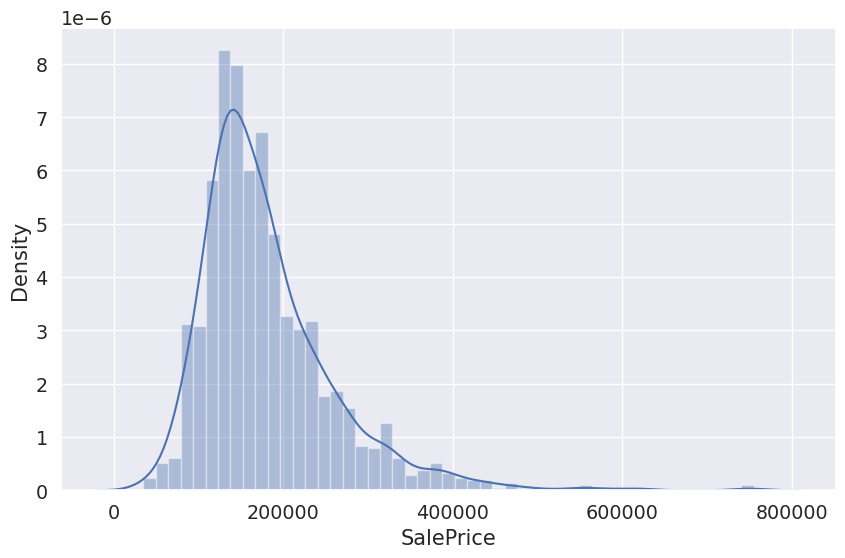

In [73]:
#Plotting the target variable - SalePrice
plt.figure(figsize=(10,6))
sns.distplot(train_data_set['SalePrice'])
plt.show()

<Axes: xlabel='TransformedPrice', ylabel='Density'>

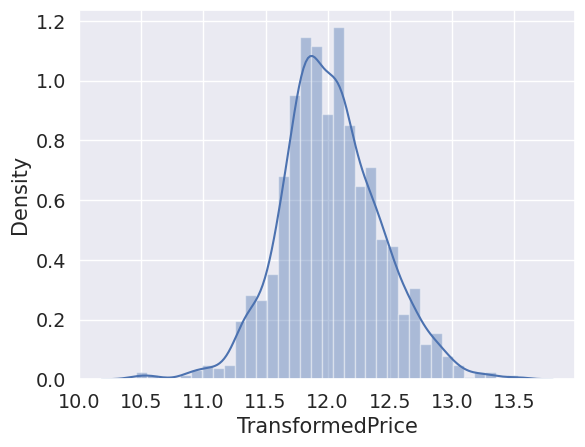

In [74]:
#applying log transformation to the target variable
train_data_set["TransformedPrice"] = np.log(train_data_set["SalePrice"])

#plottting the transformed target variable
sns.distplot(train_data_set["TransformedPrice"])



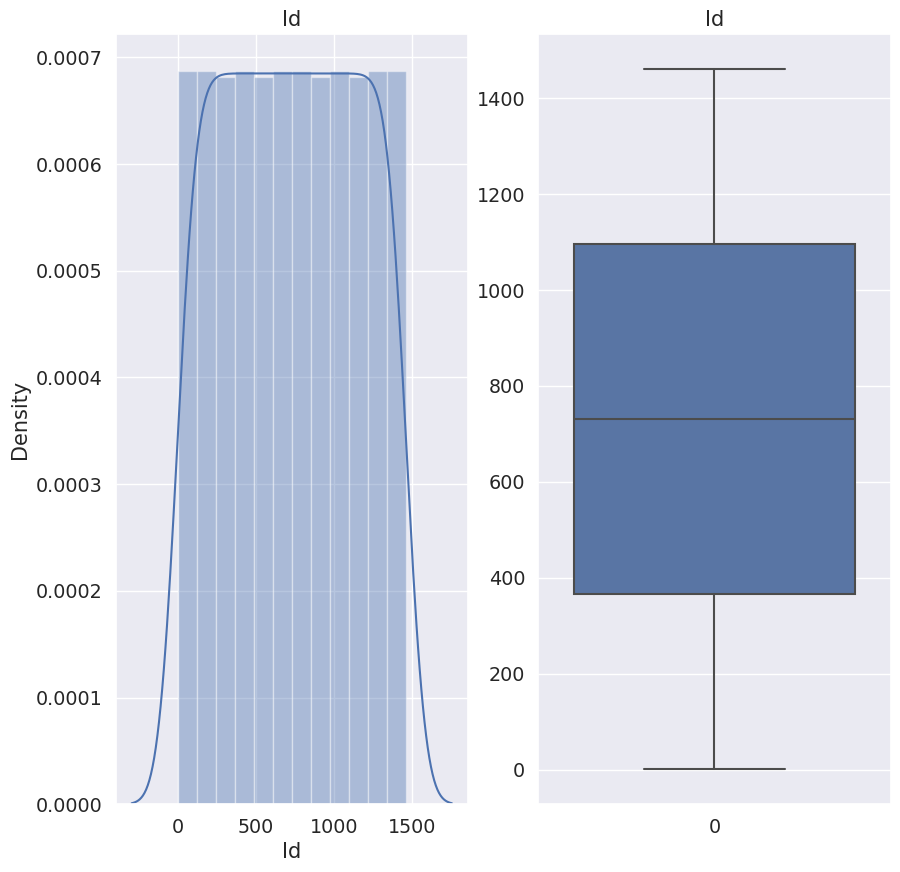

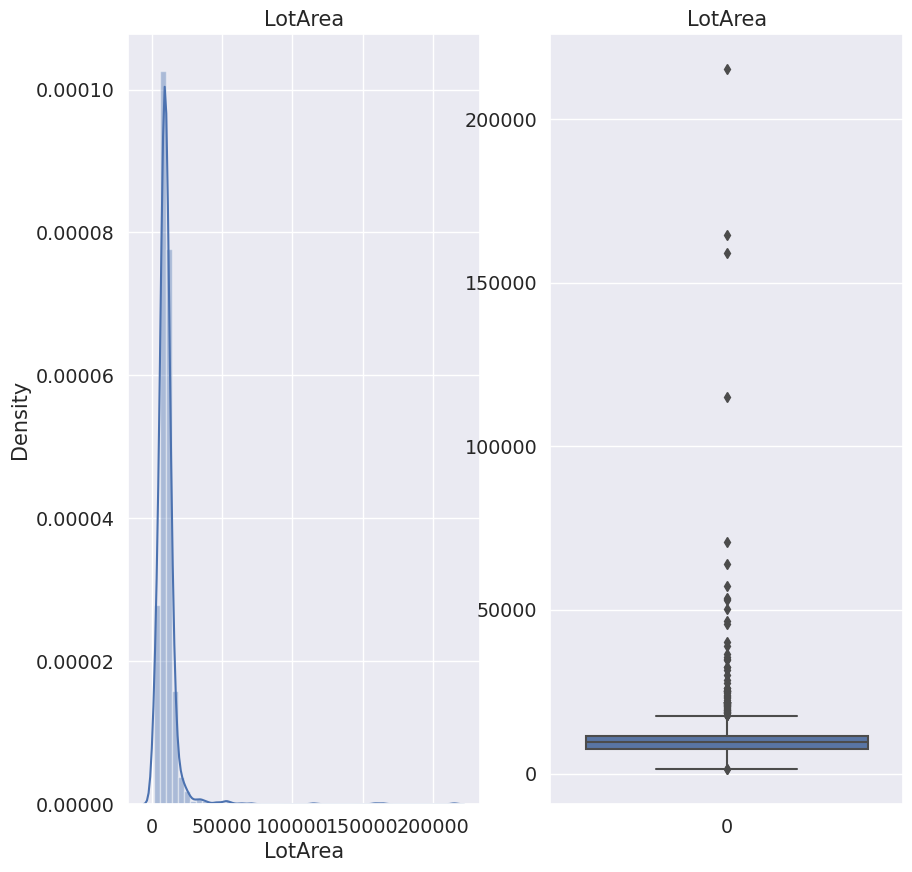

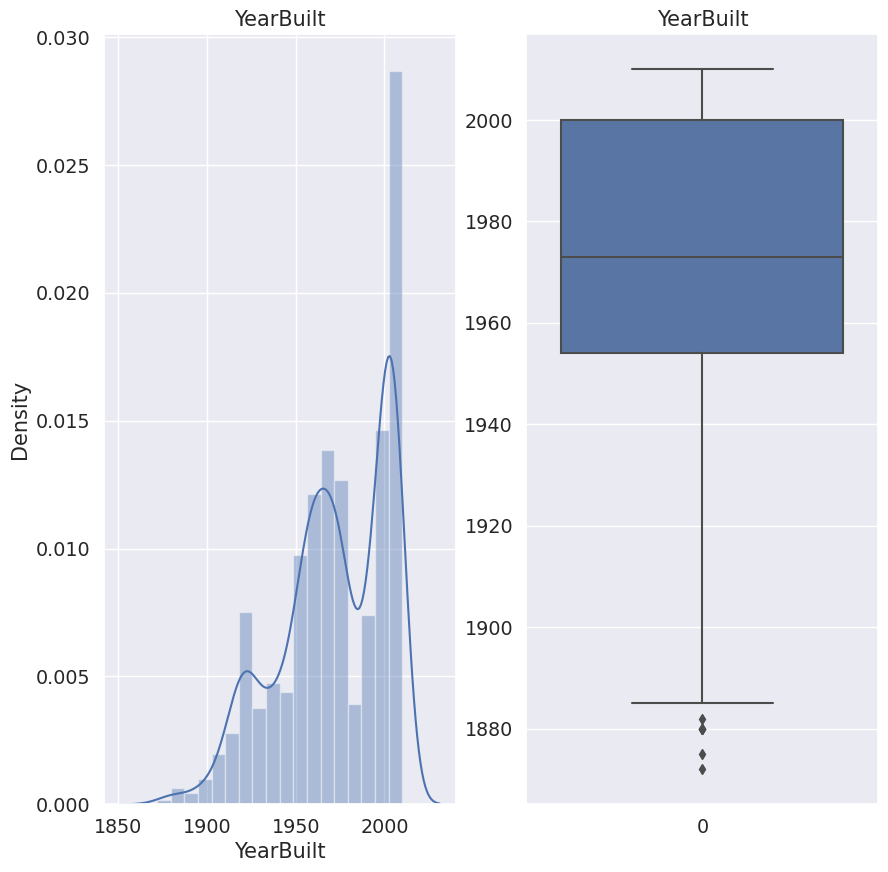

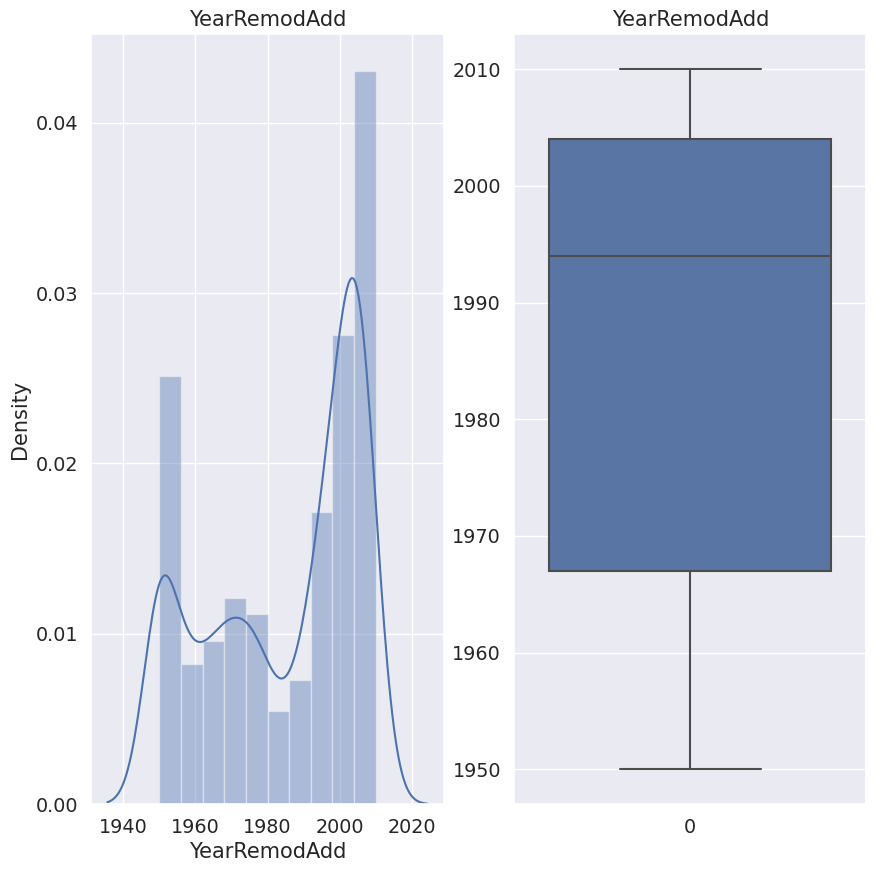

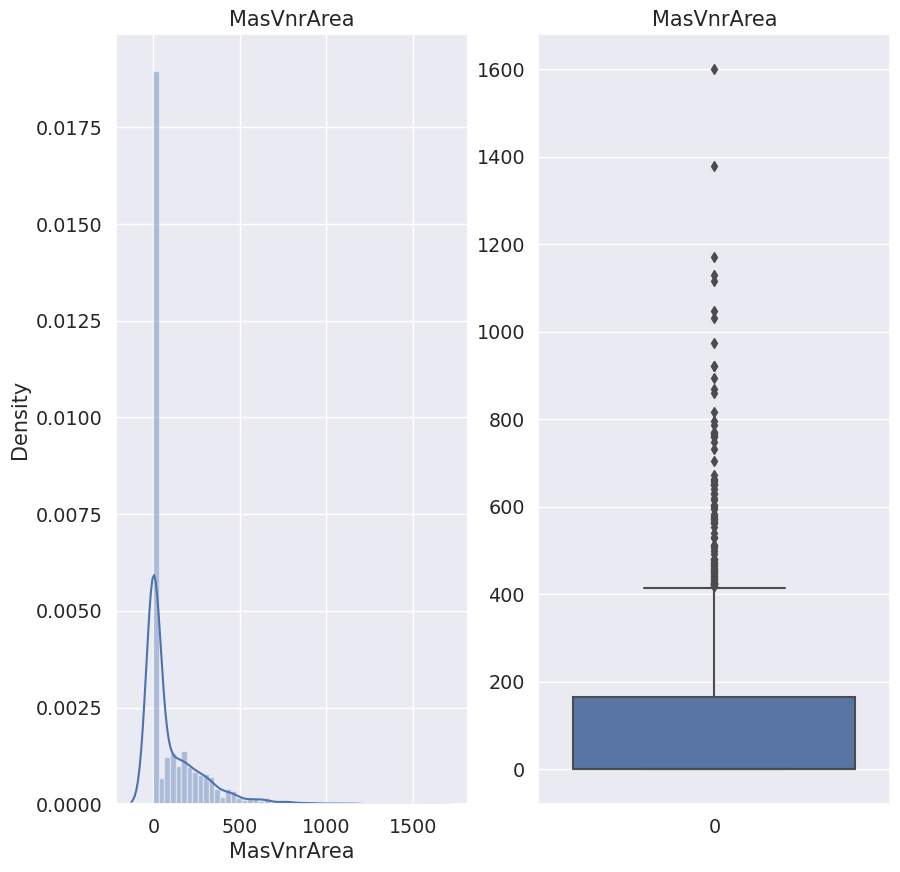

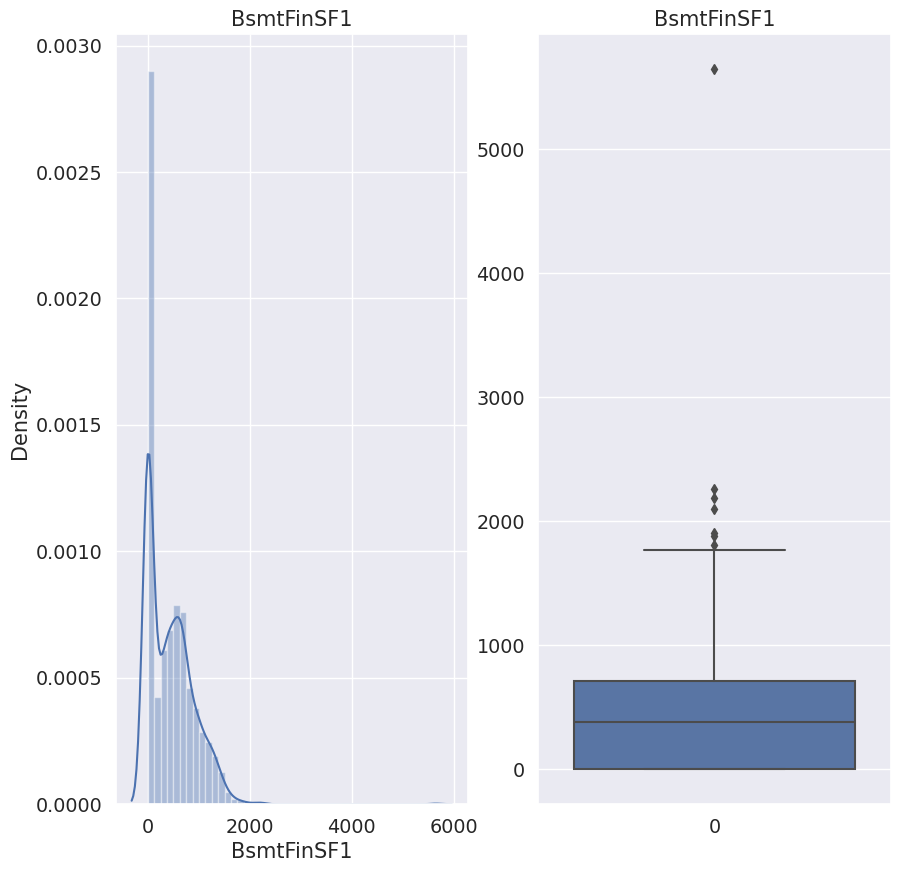

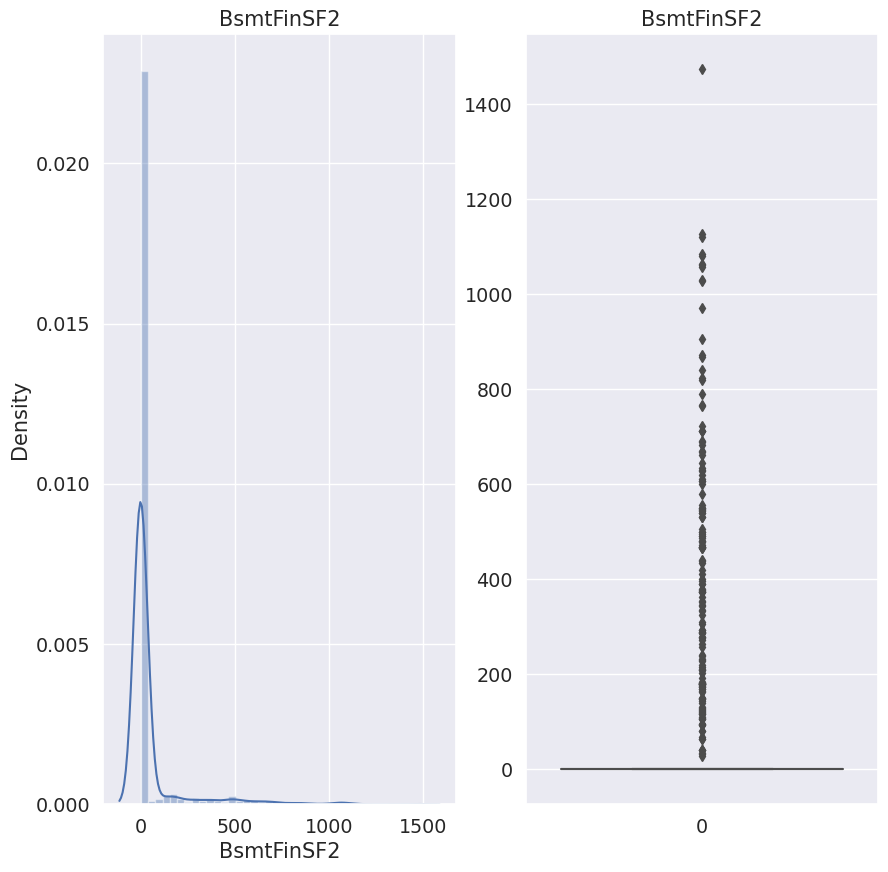

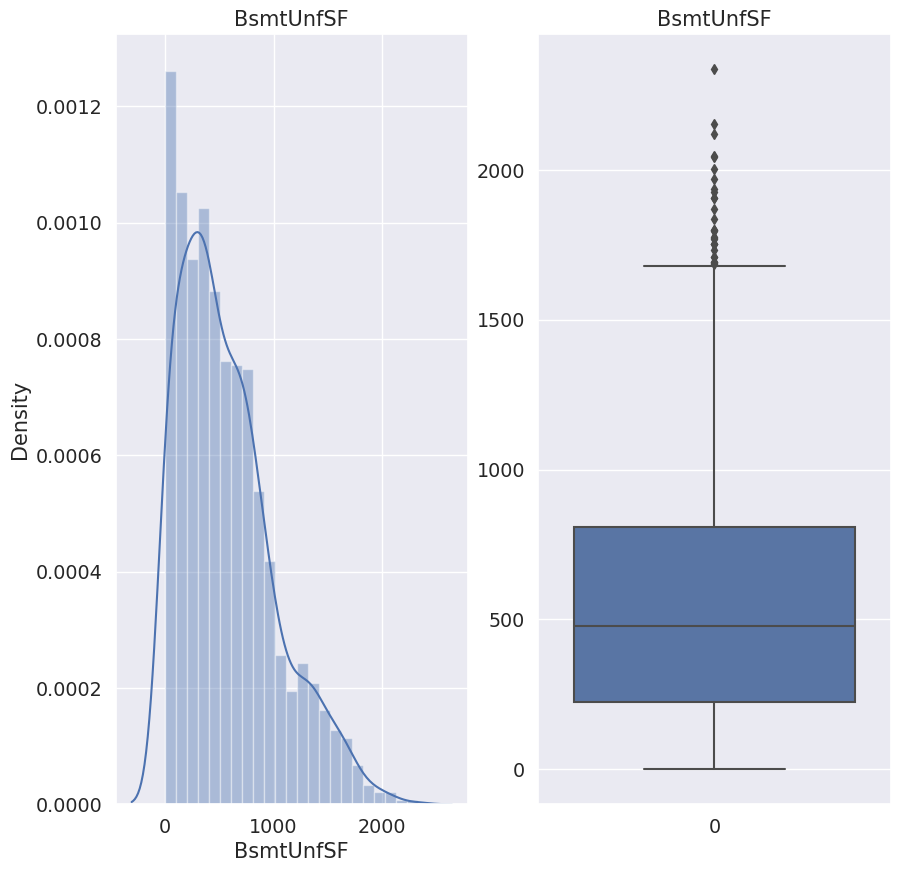

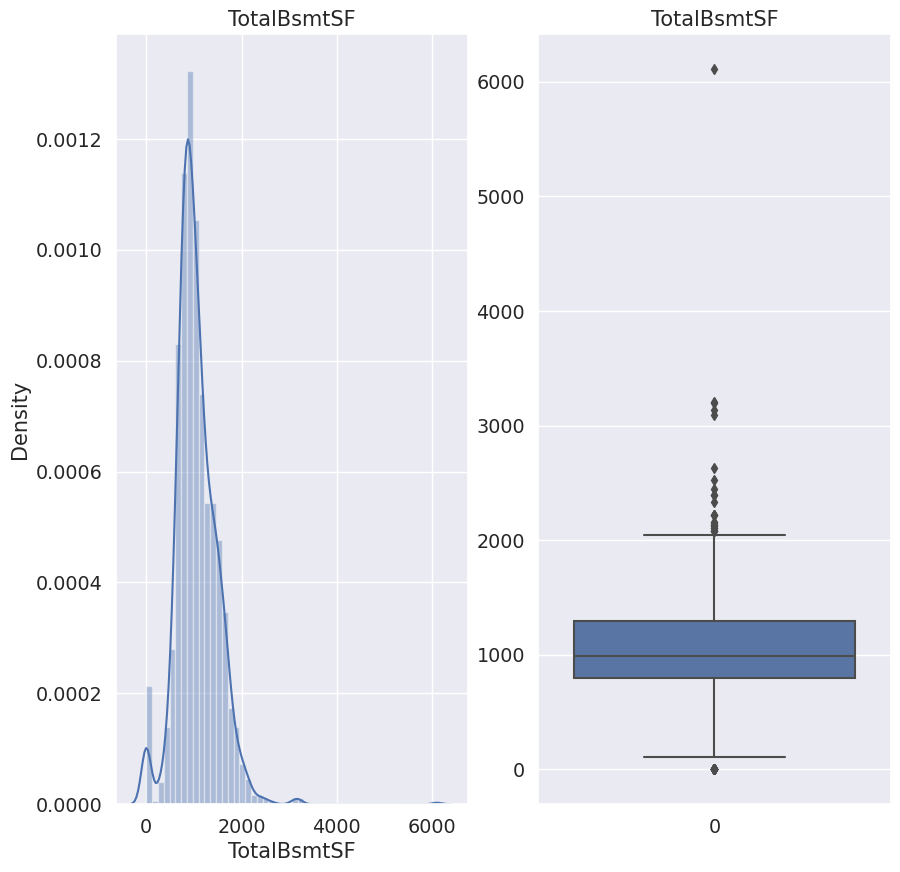

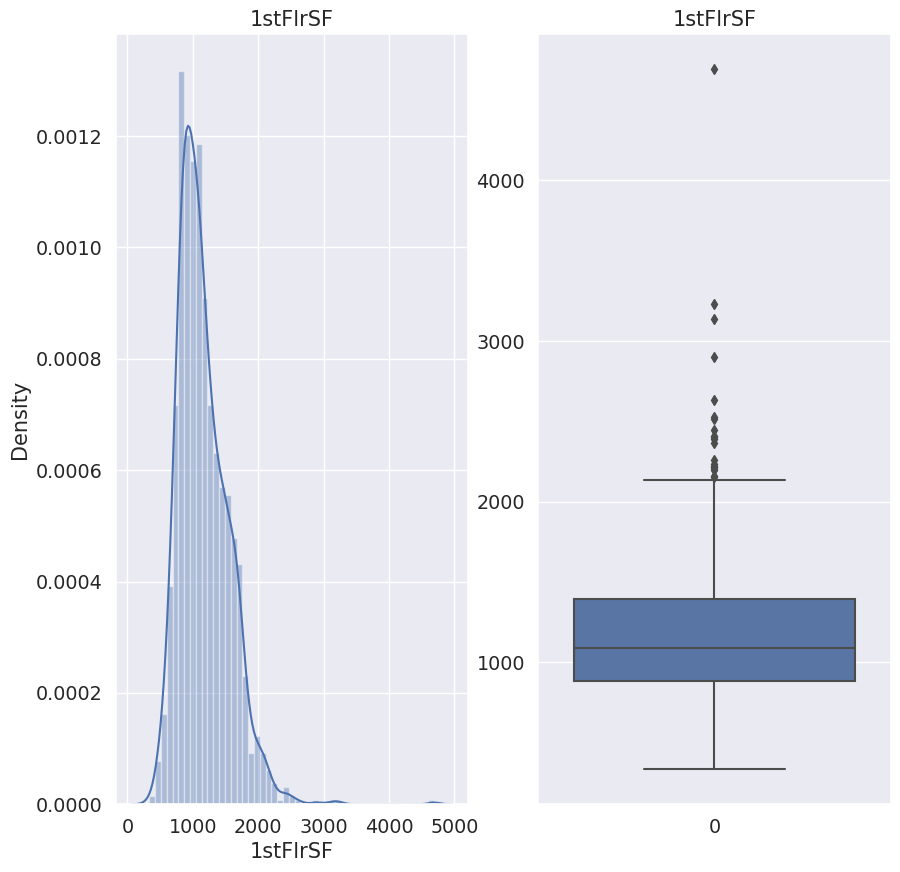

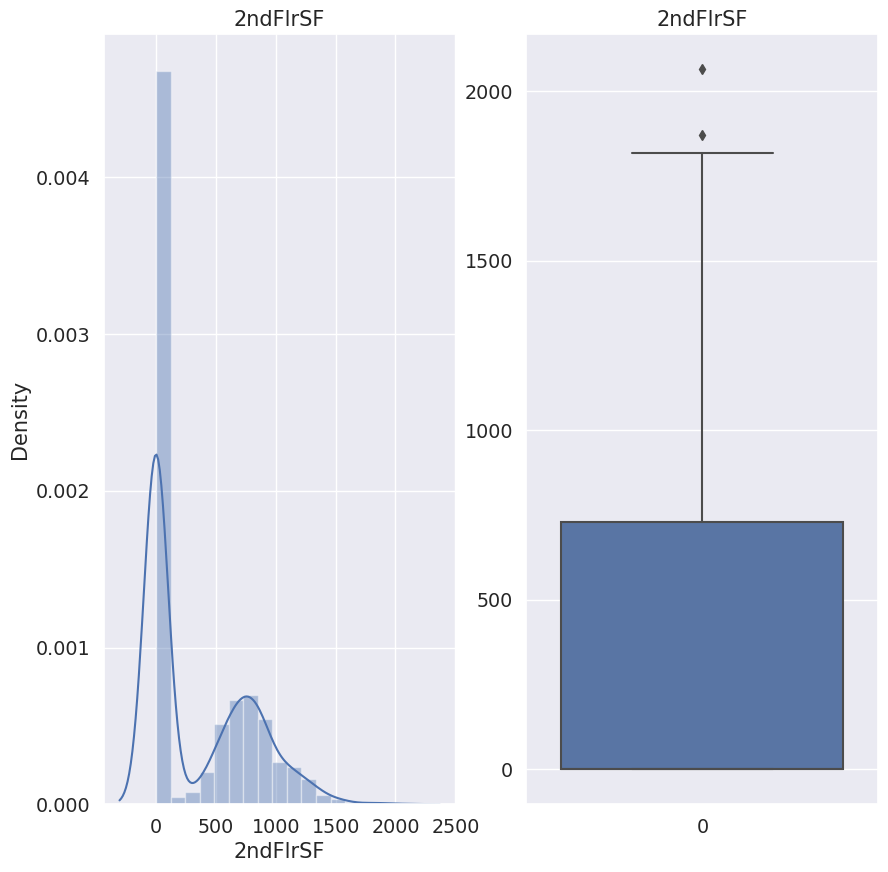

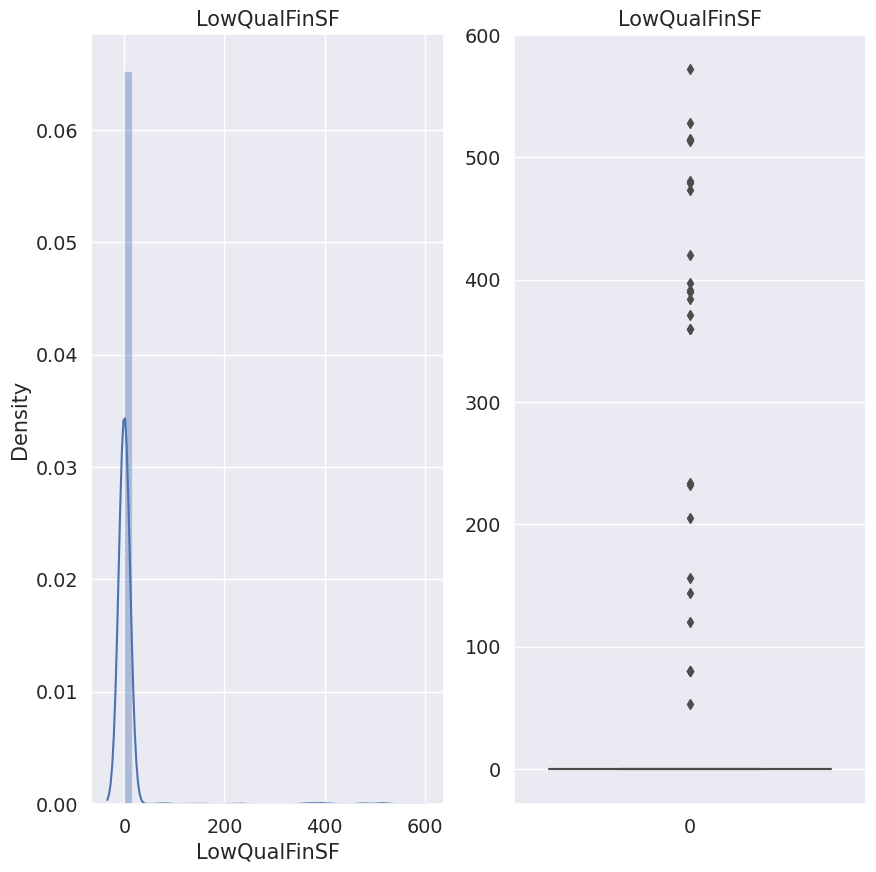

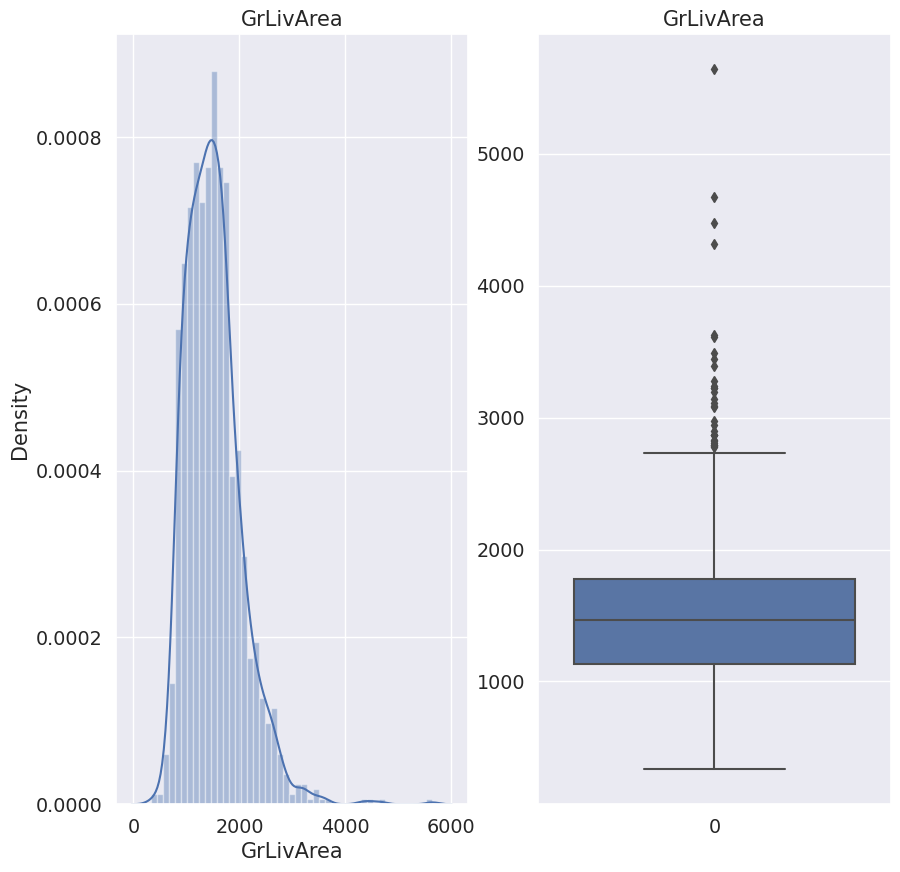

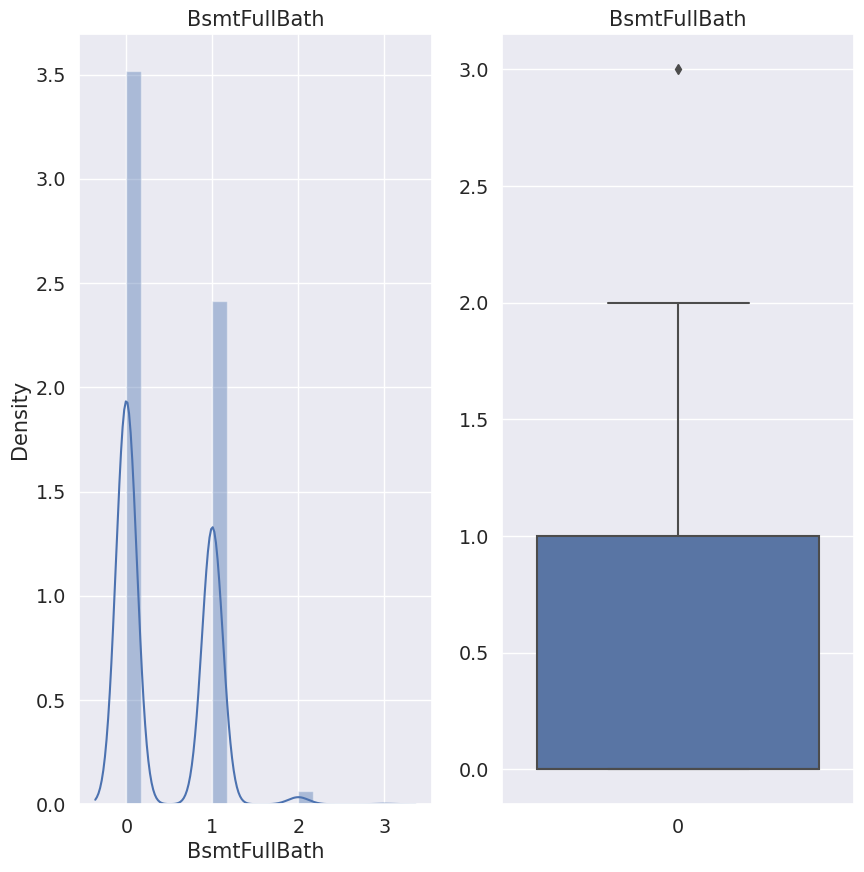

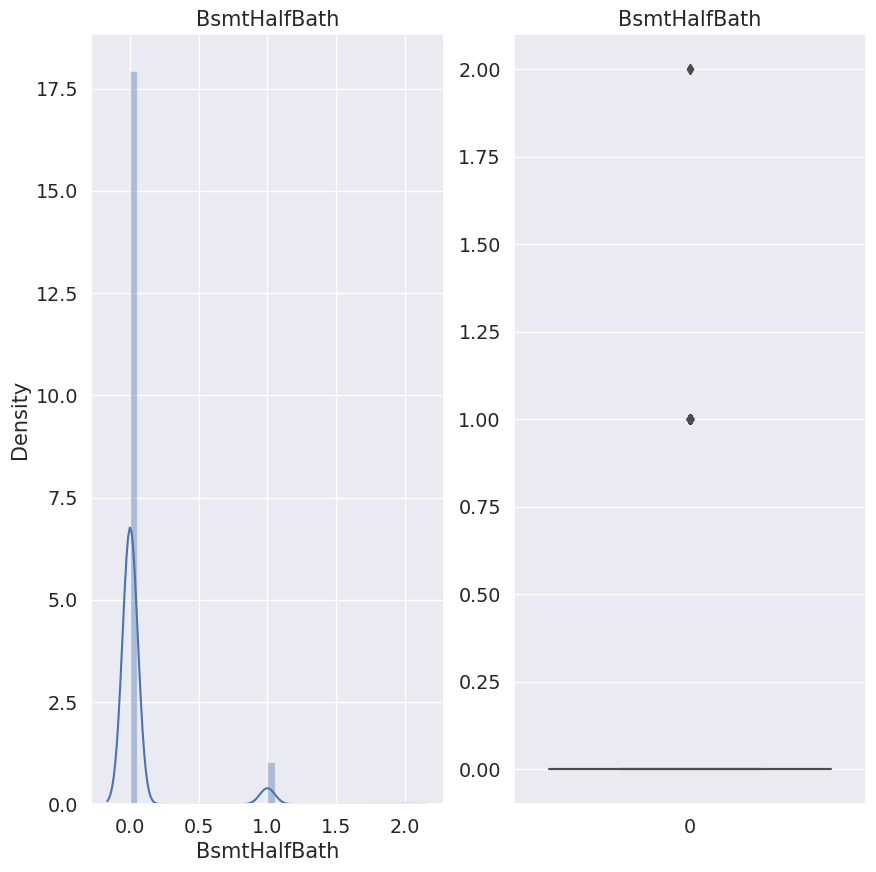

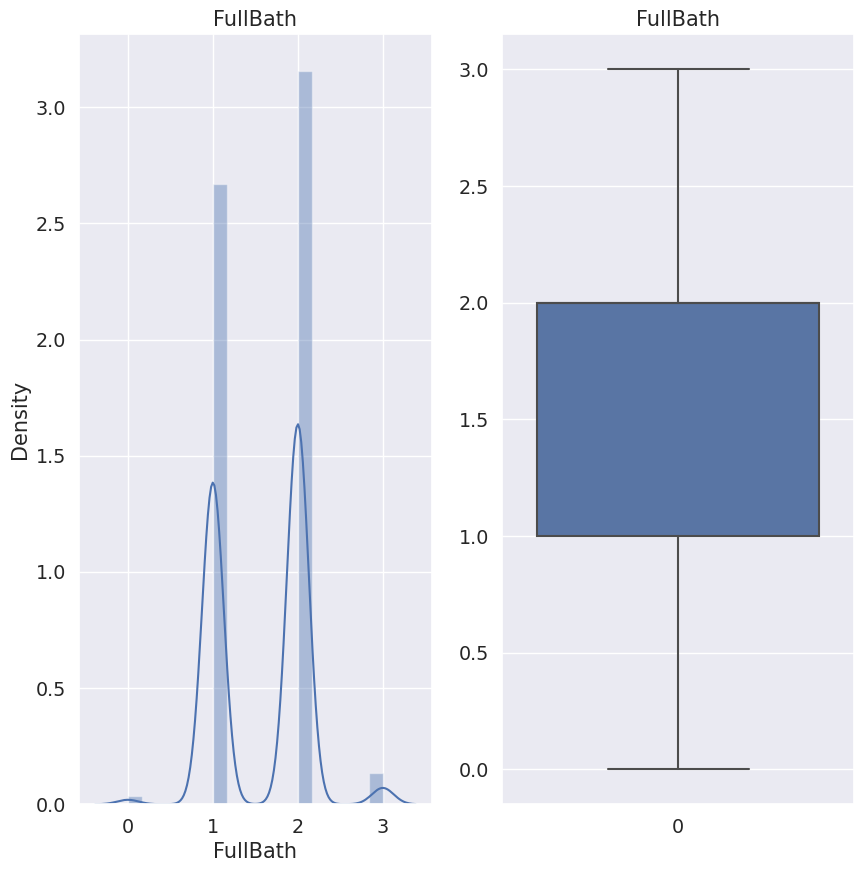

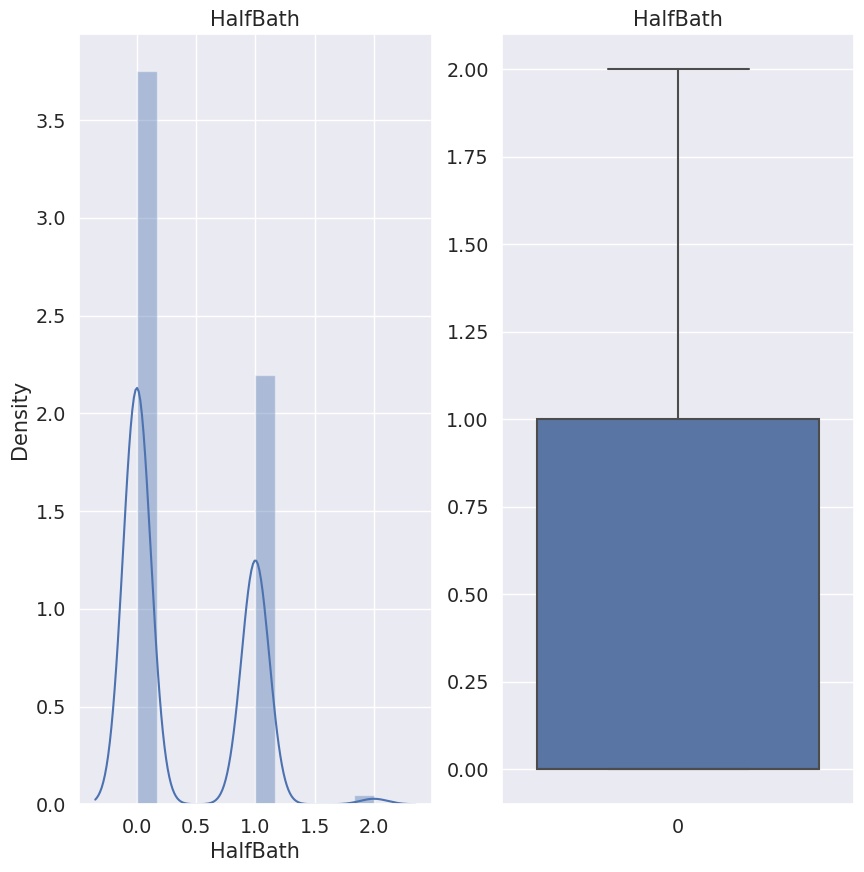

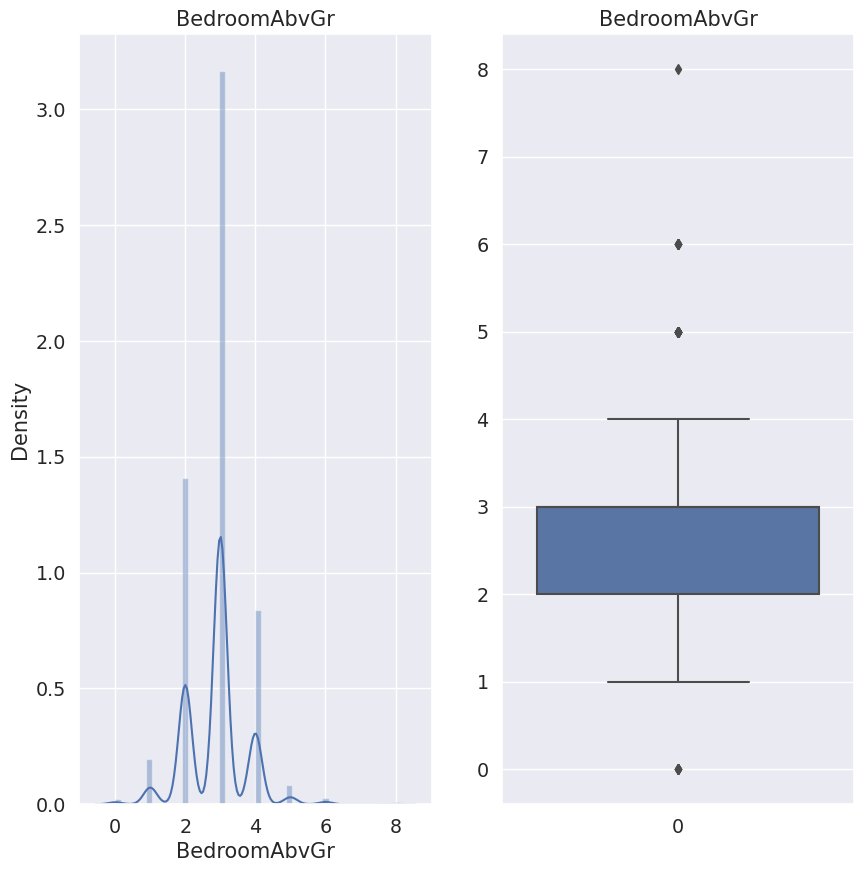

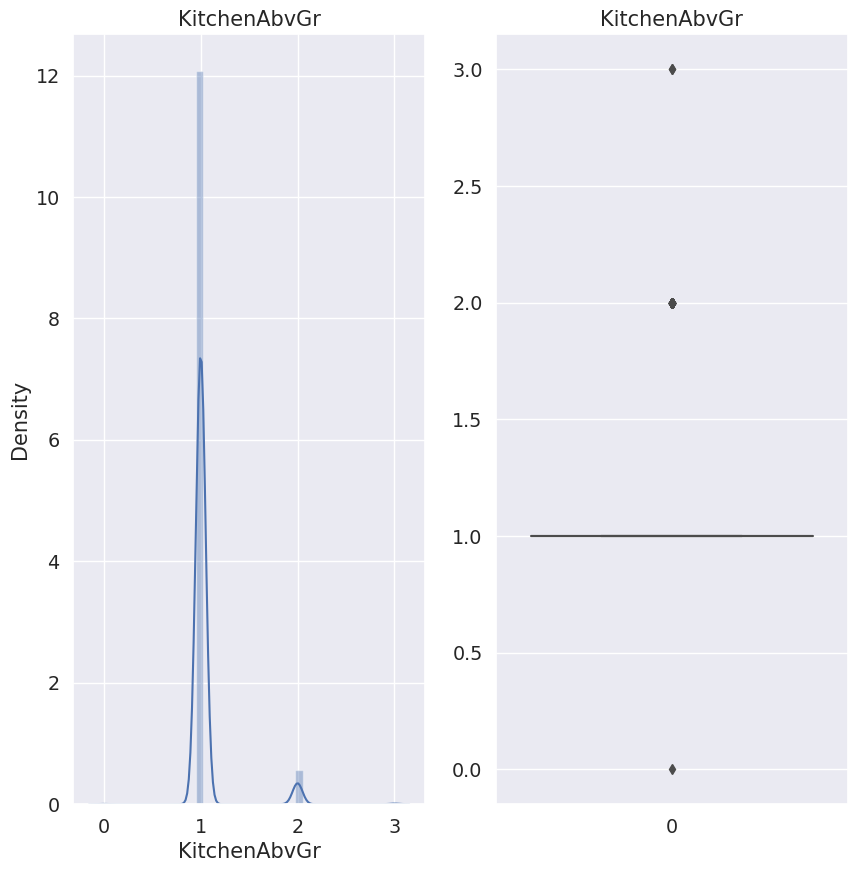

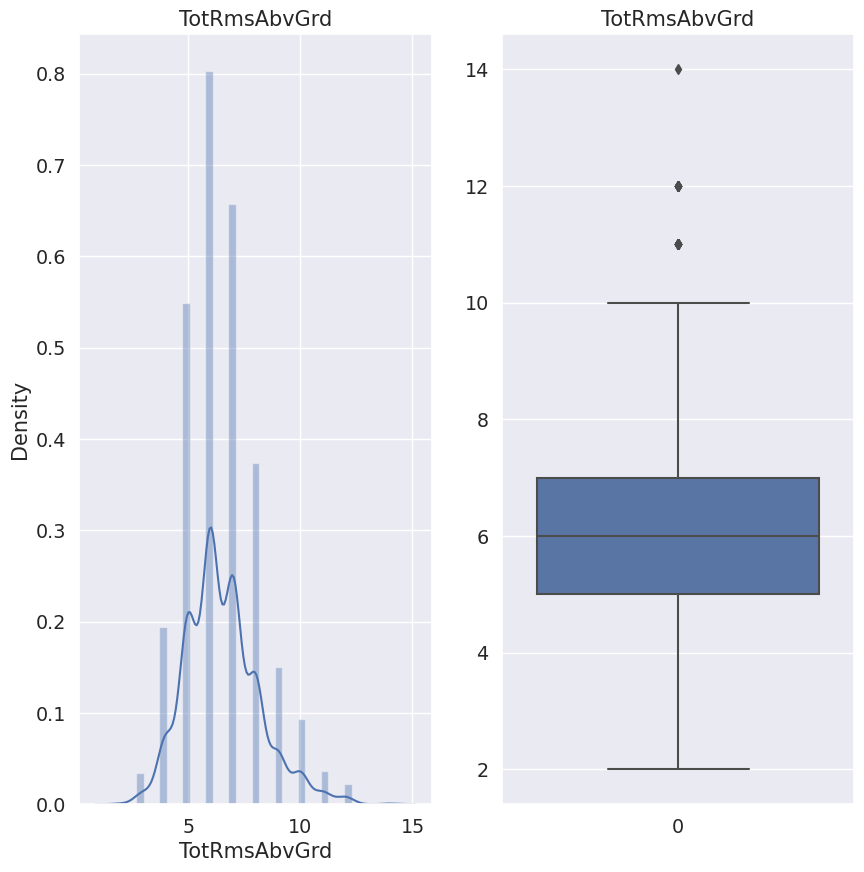

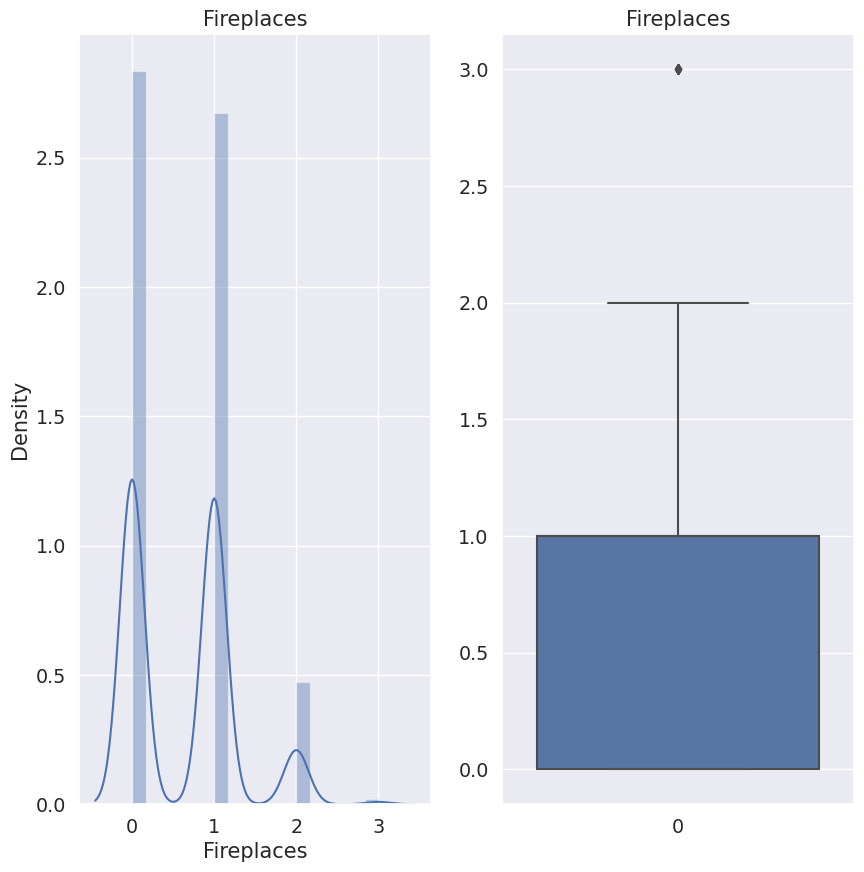

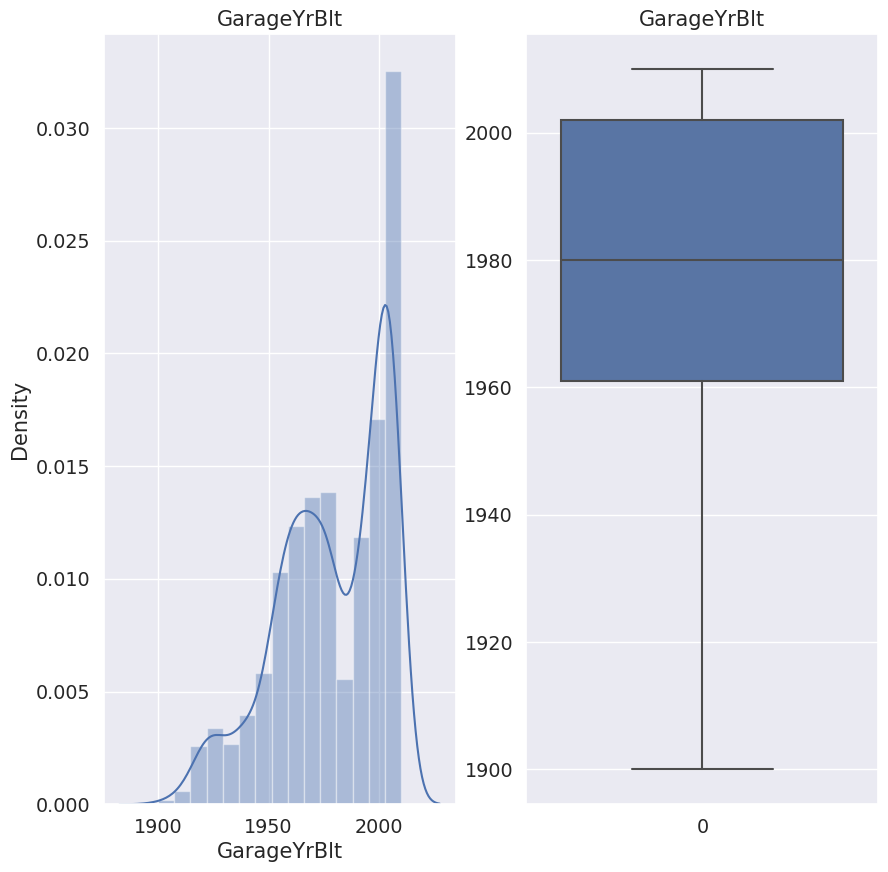

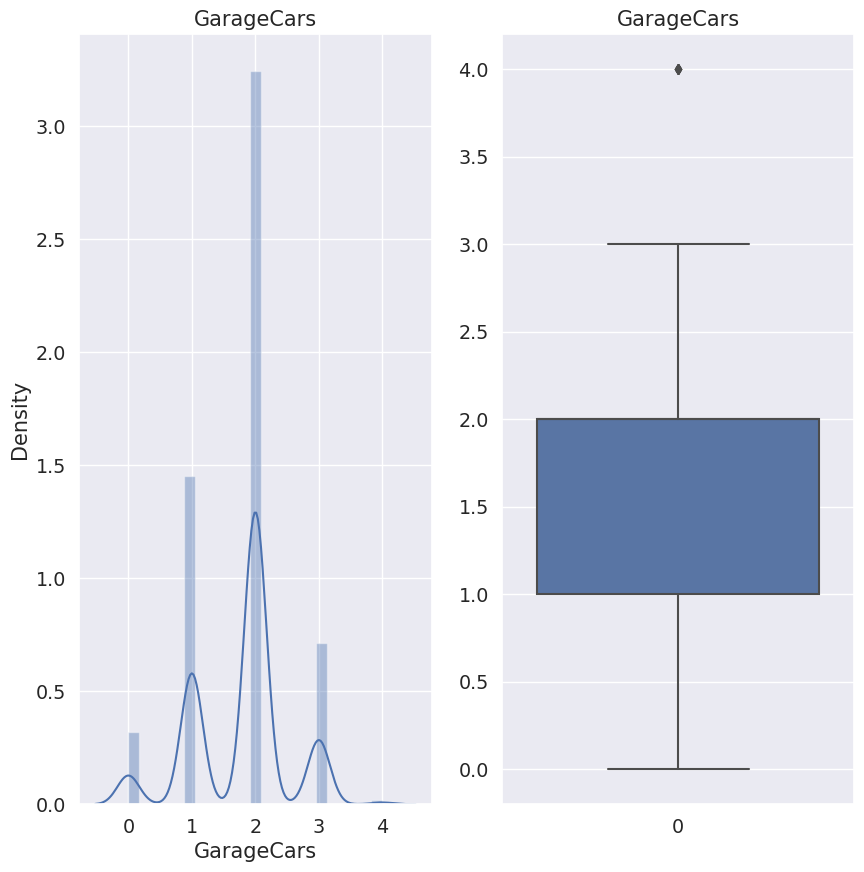

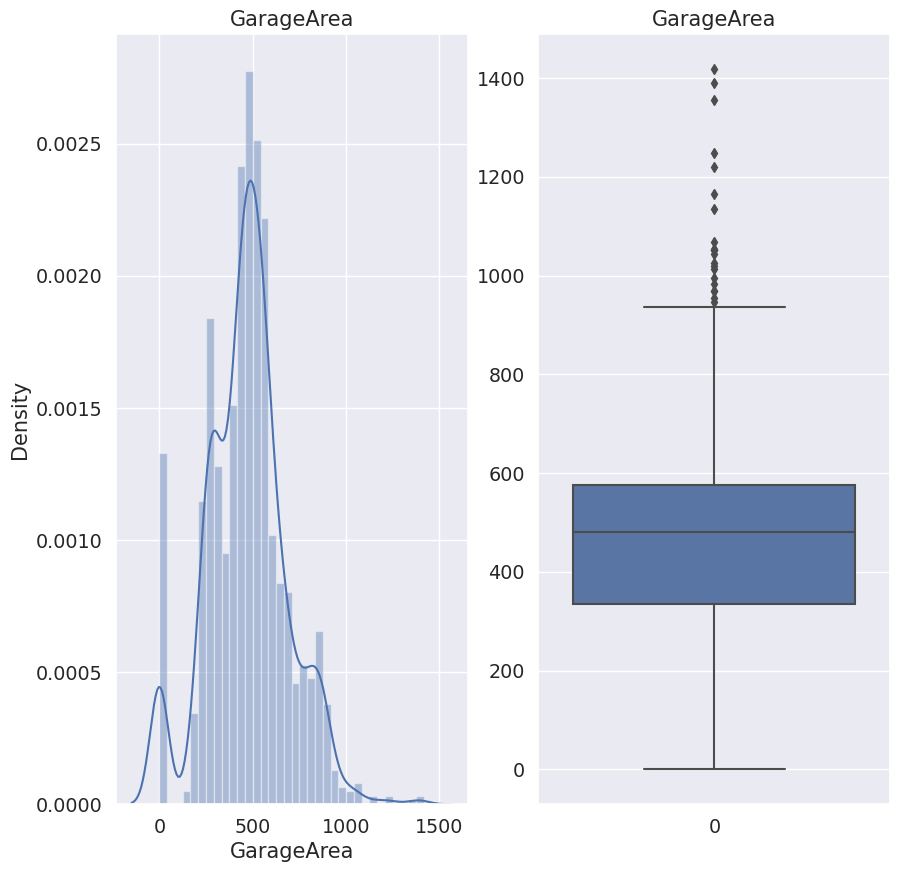

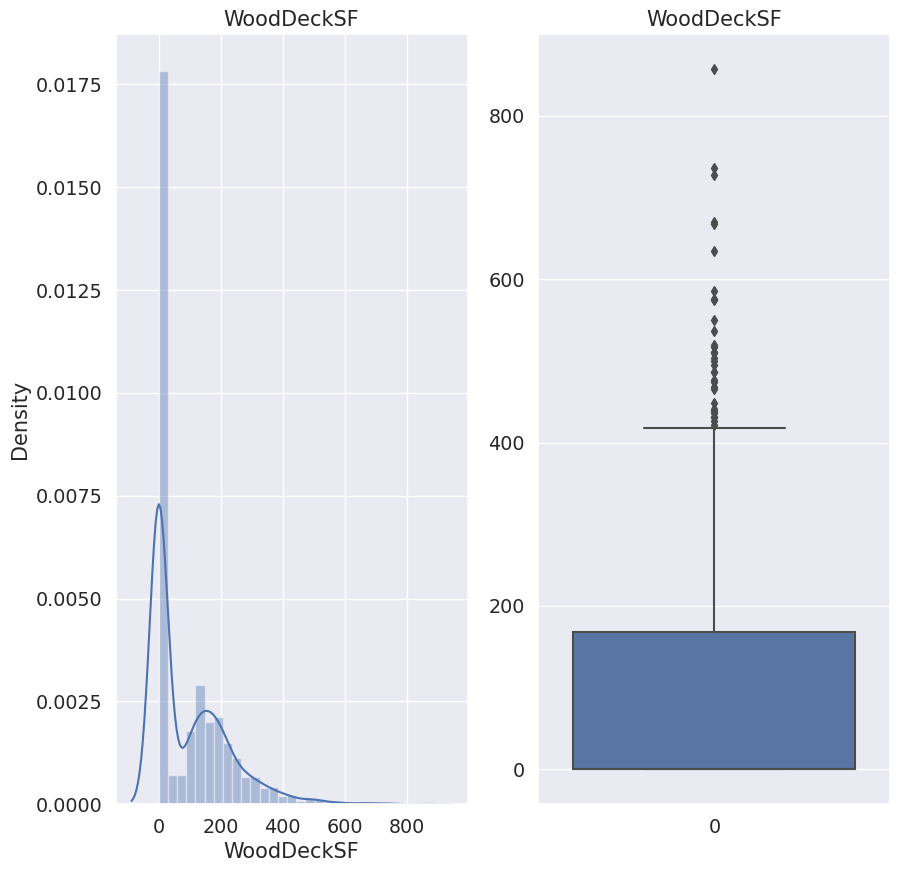

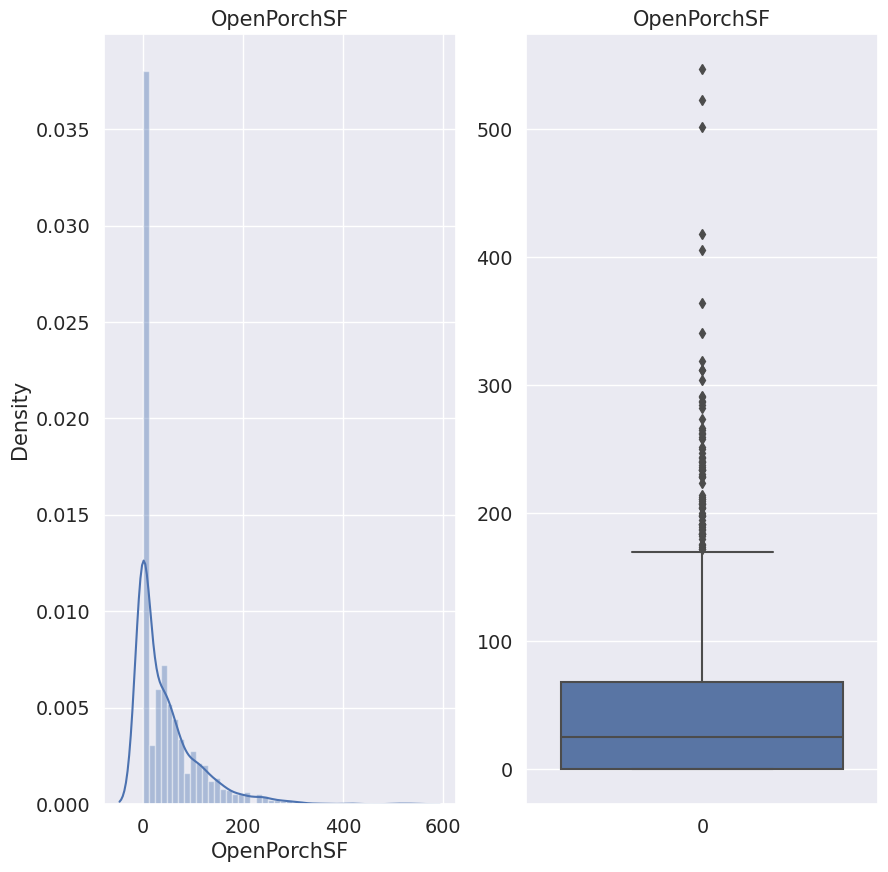

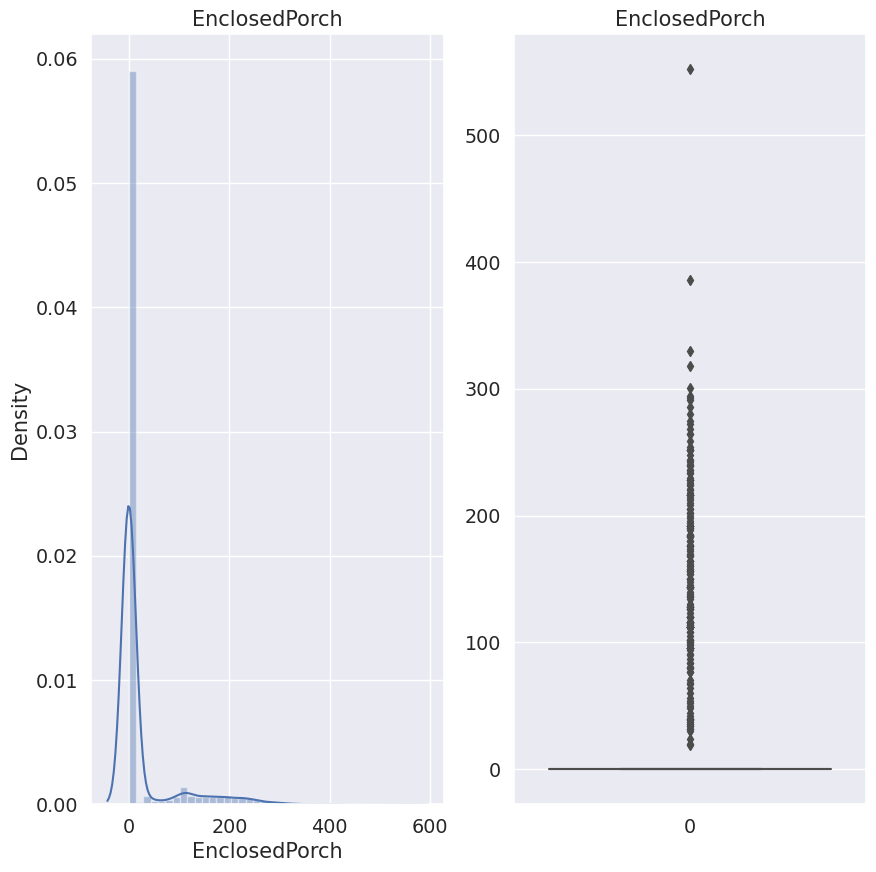

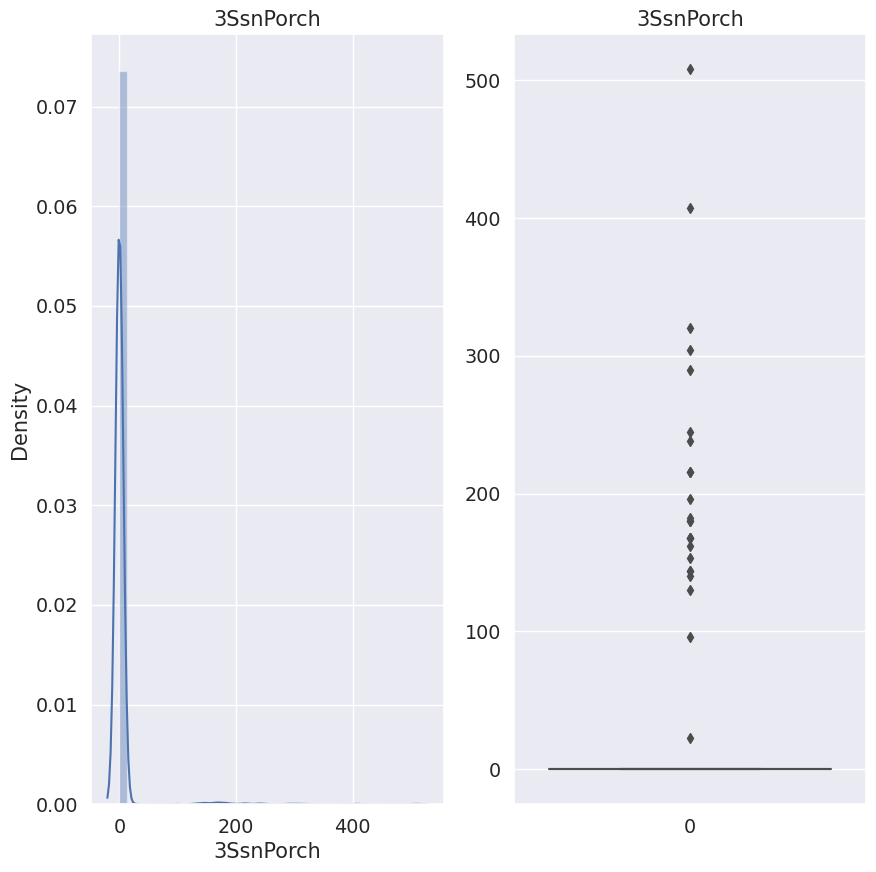

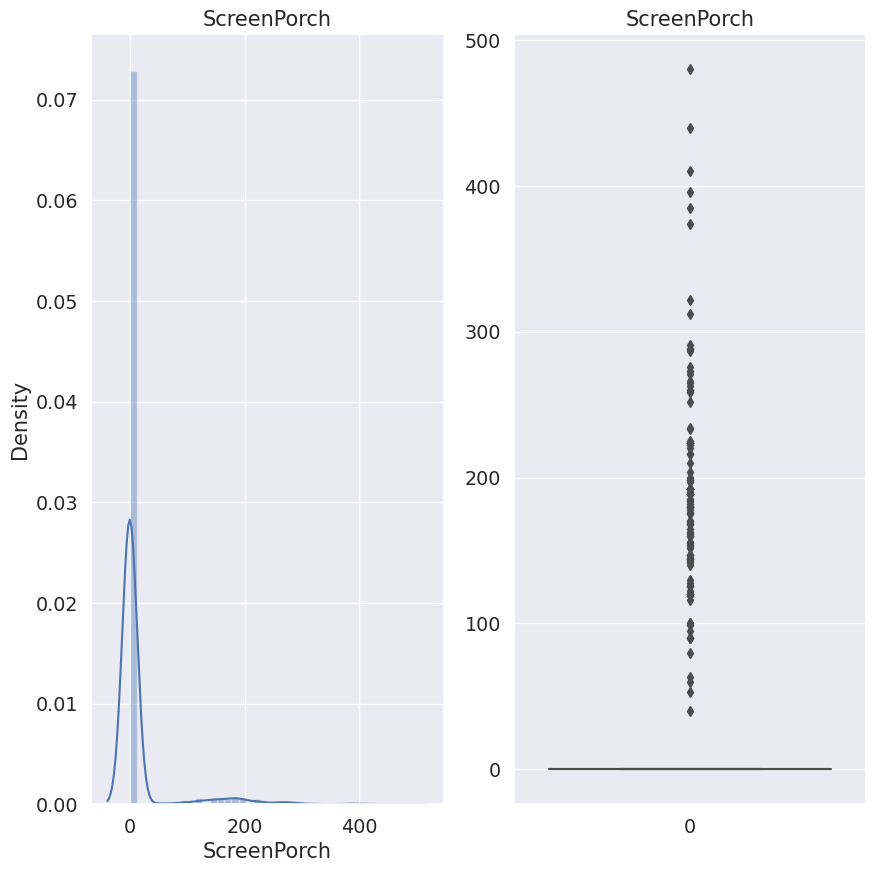

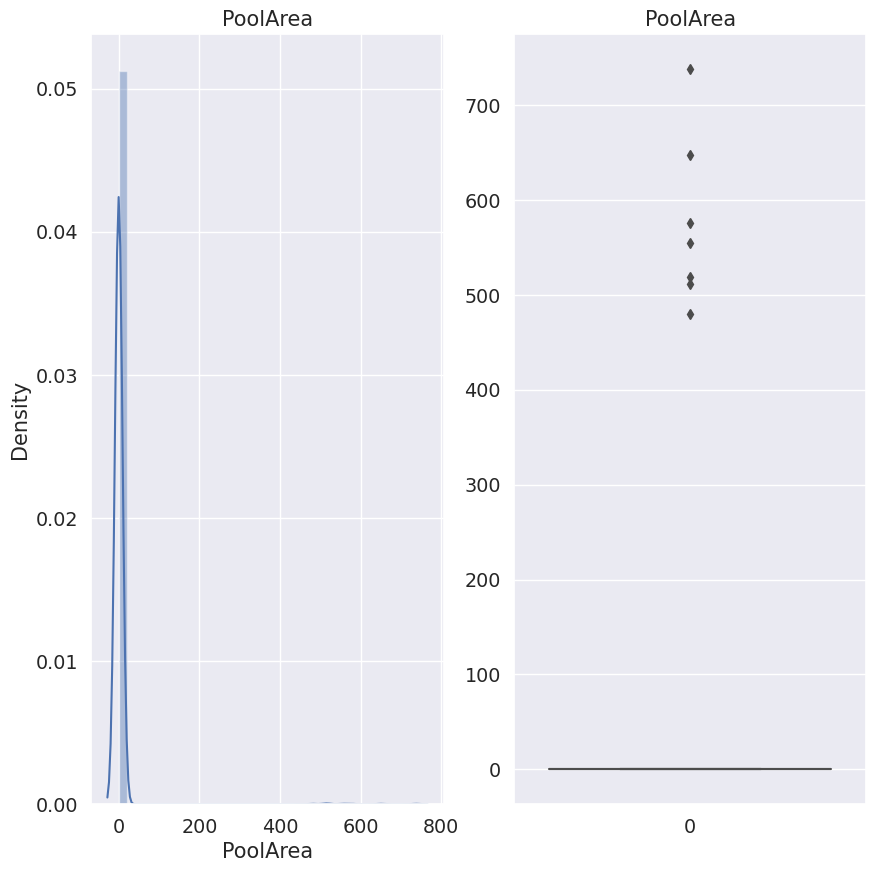

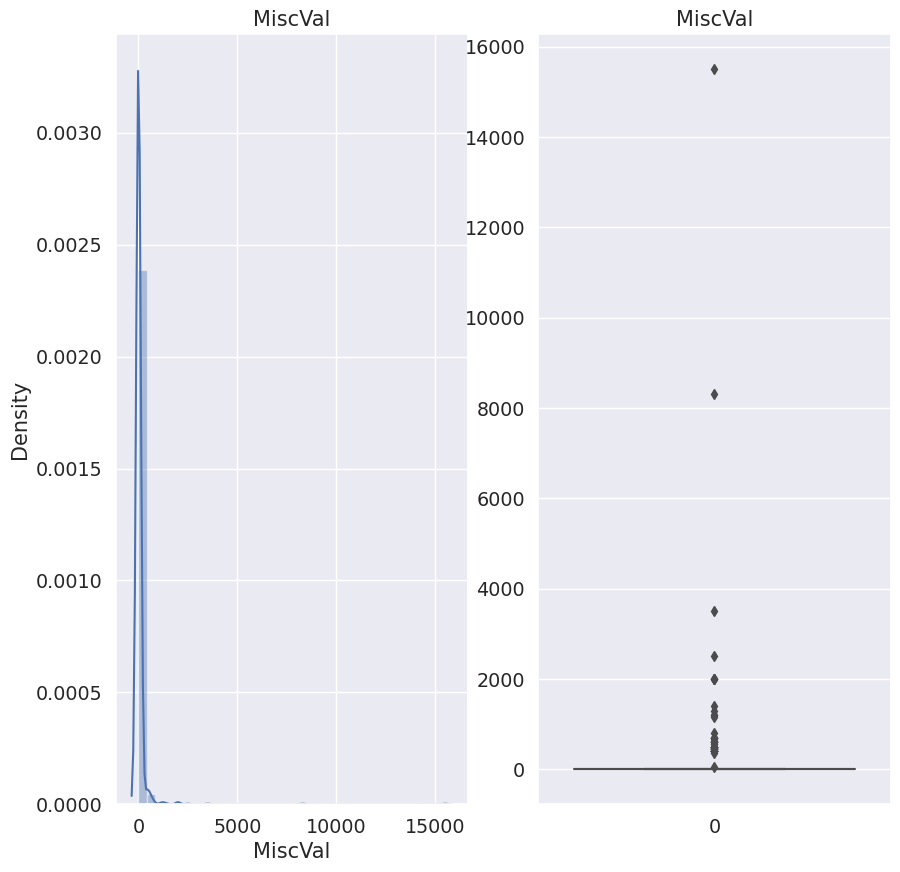

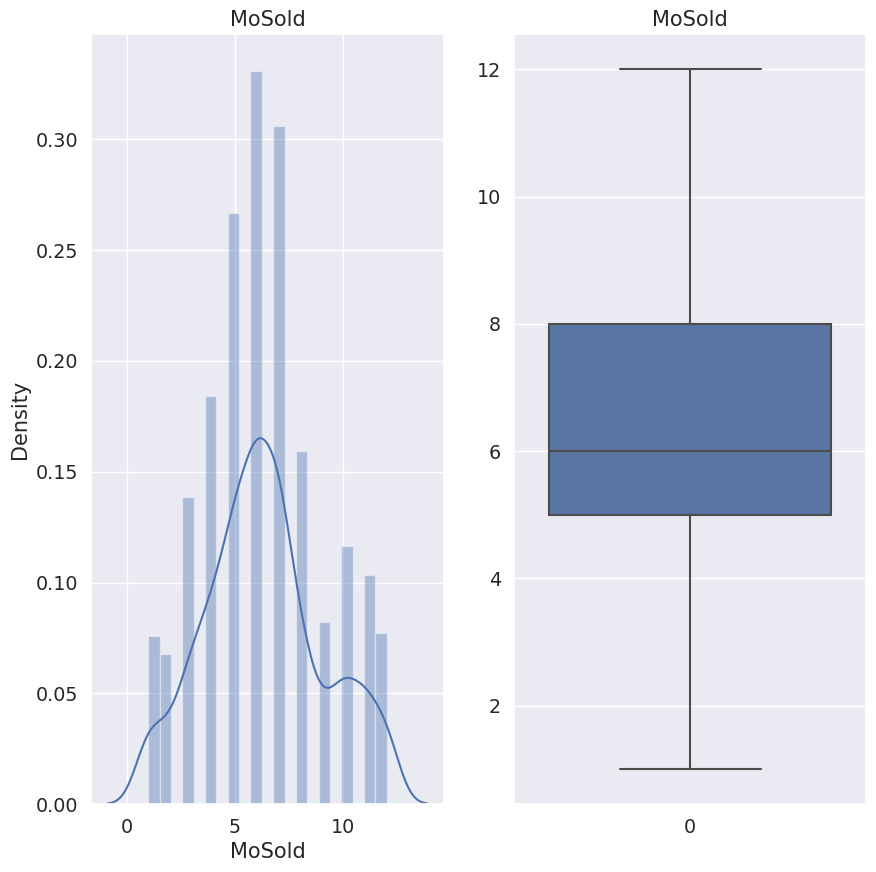

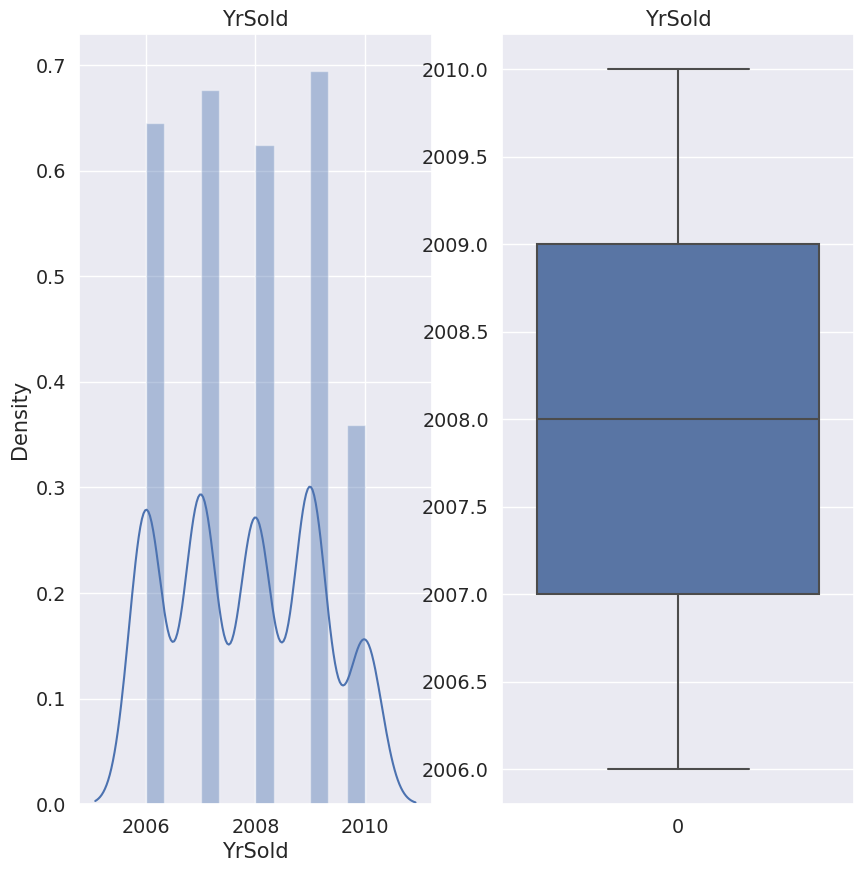

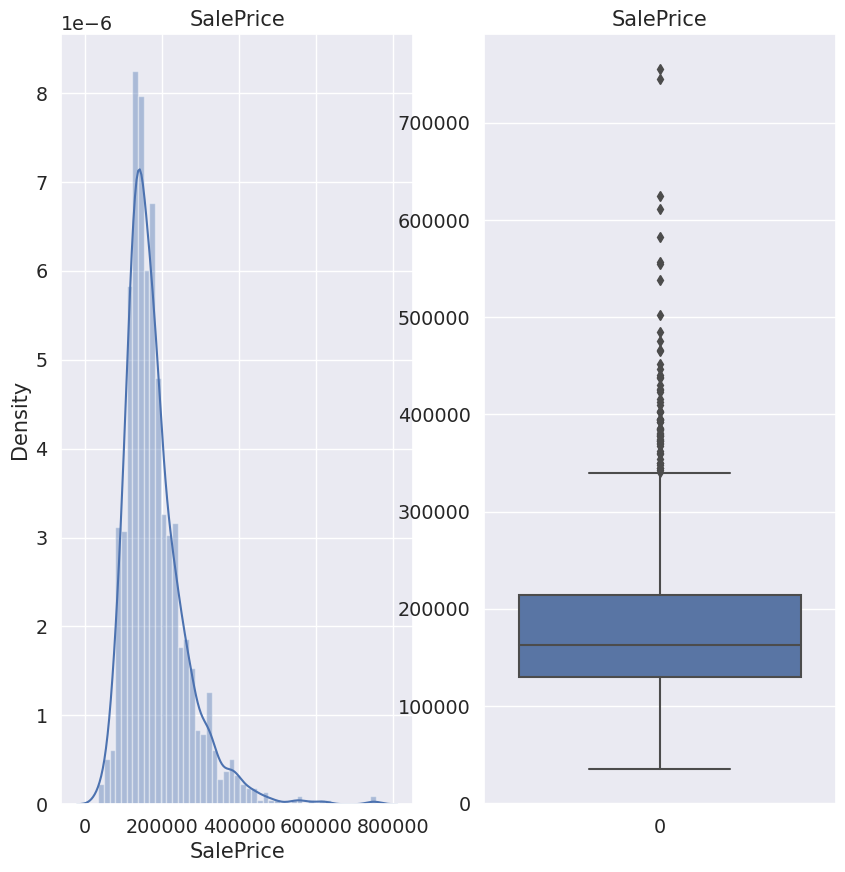

In [108]:
## Uni-variate Analysis on Numerical Features

#plottting the numerical features
for feature in numerical_features_list:
    plt.figure(figsize=(10,10))

    plt.subplot(1,2,1)
    sns.distplot(train_data_set[feature])
    plt.title(feature)

    plt.subplot(1,2,2)
    sns.boxplot(train_data_set[feature])
    plt.title(feature)


In [76]:
#Checking the value counts of categorical features and check if any feature has only one value
for feature in categorical_features_list:
    if len(train_data_set[feature].value_counts()) == 1:
        print(feature)

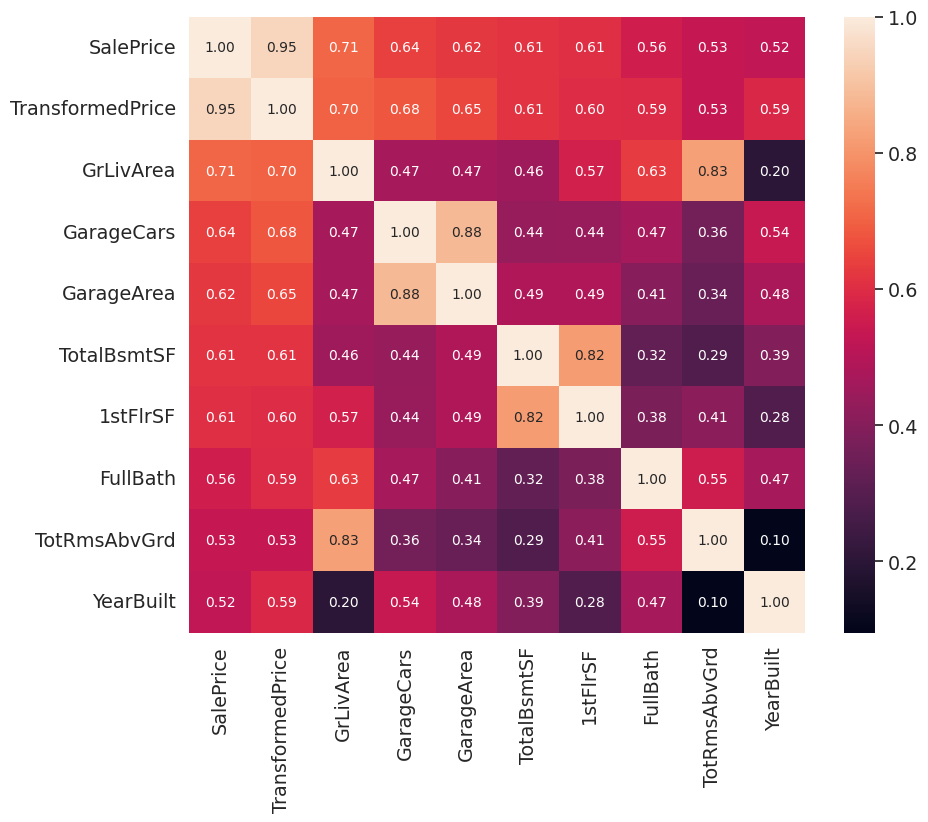

In [78]:
#plotting the correlation matrix wih target variable

plt.figure(figsize=(10,8))
k = 10 #number of variables for heatmap
cols = train_data_set.corr().nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_data_set[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

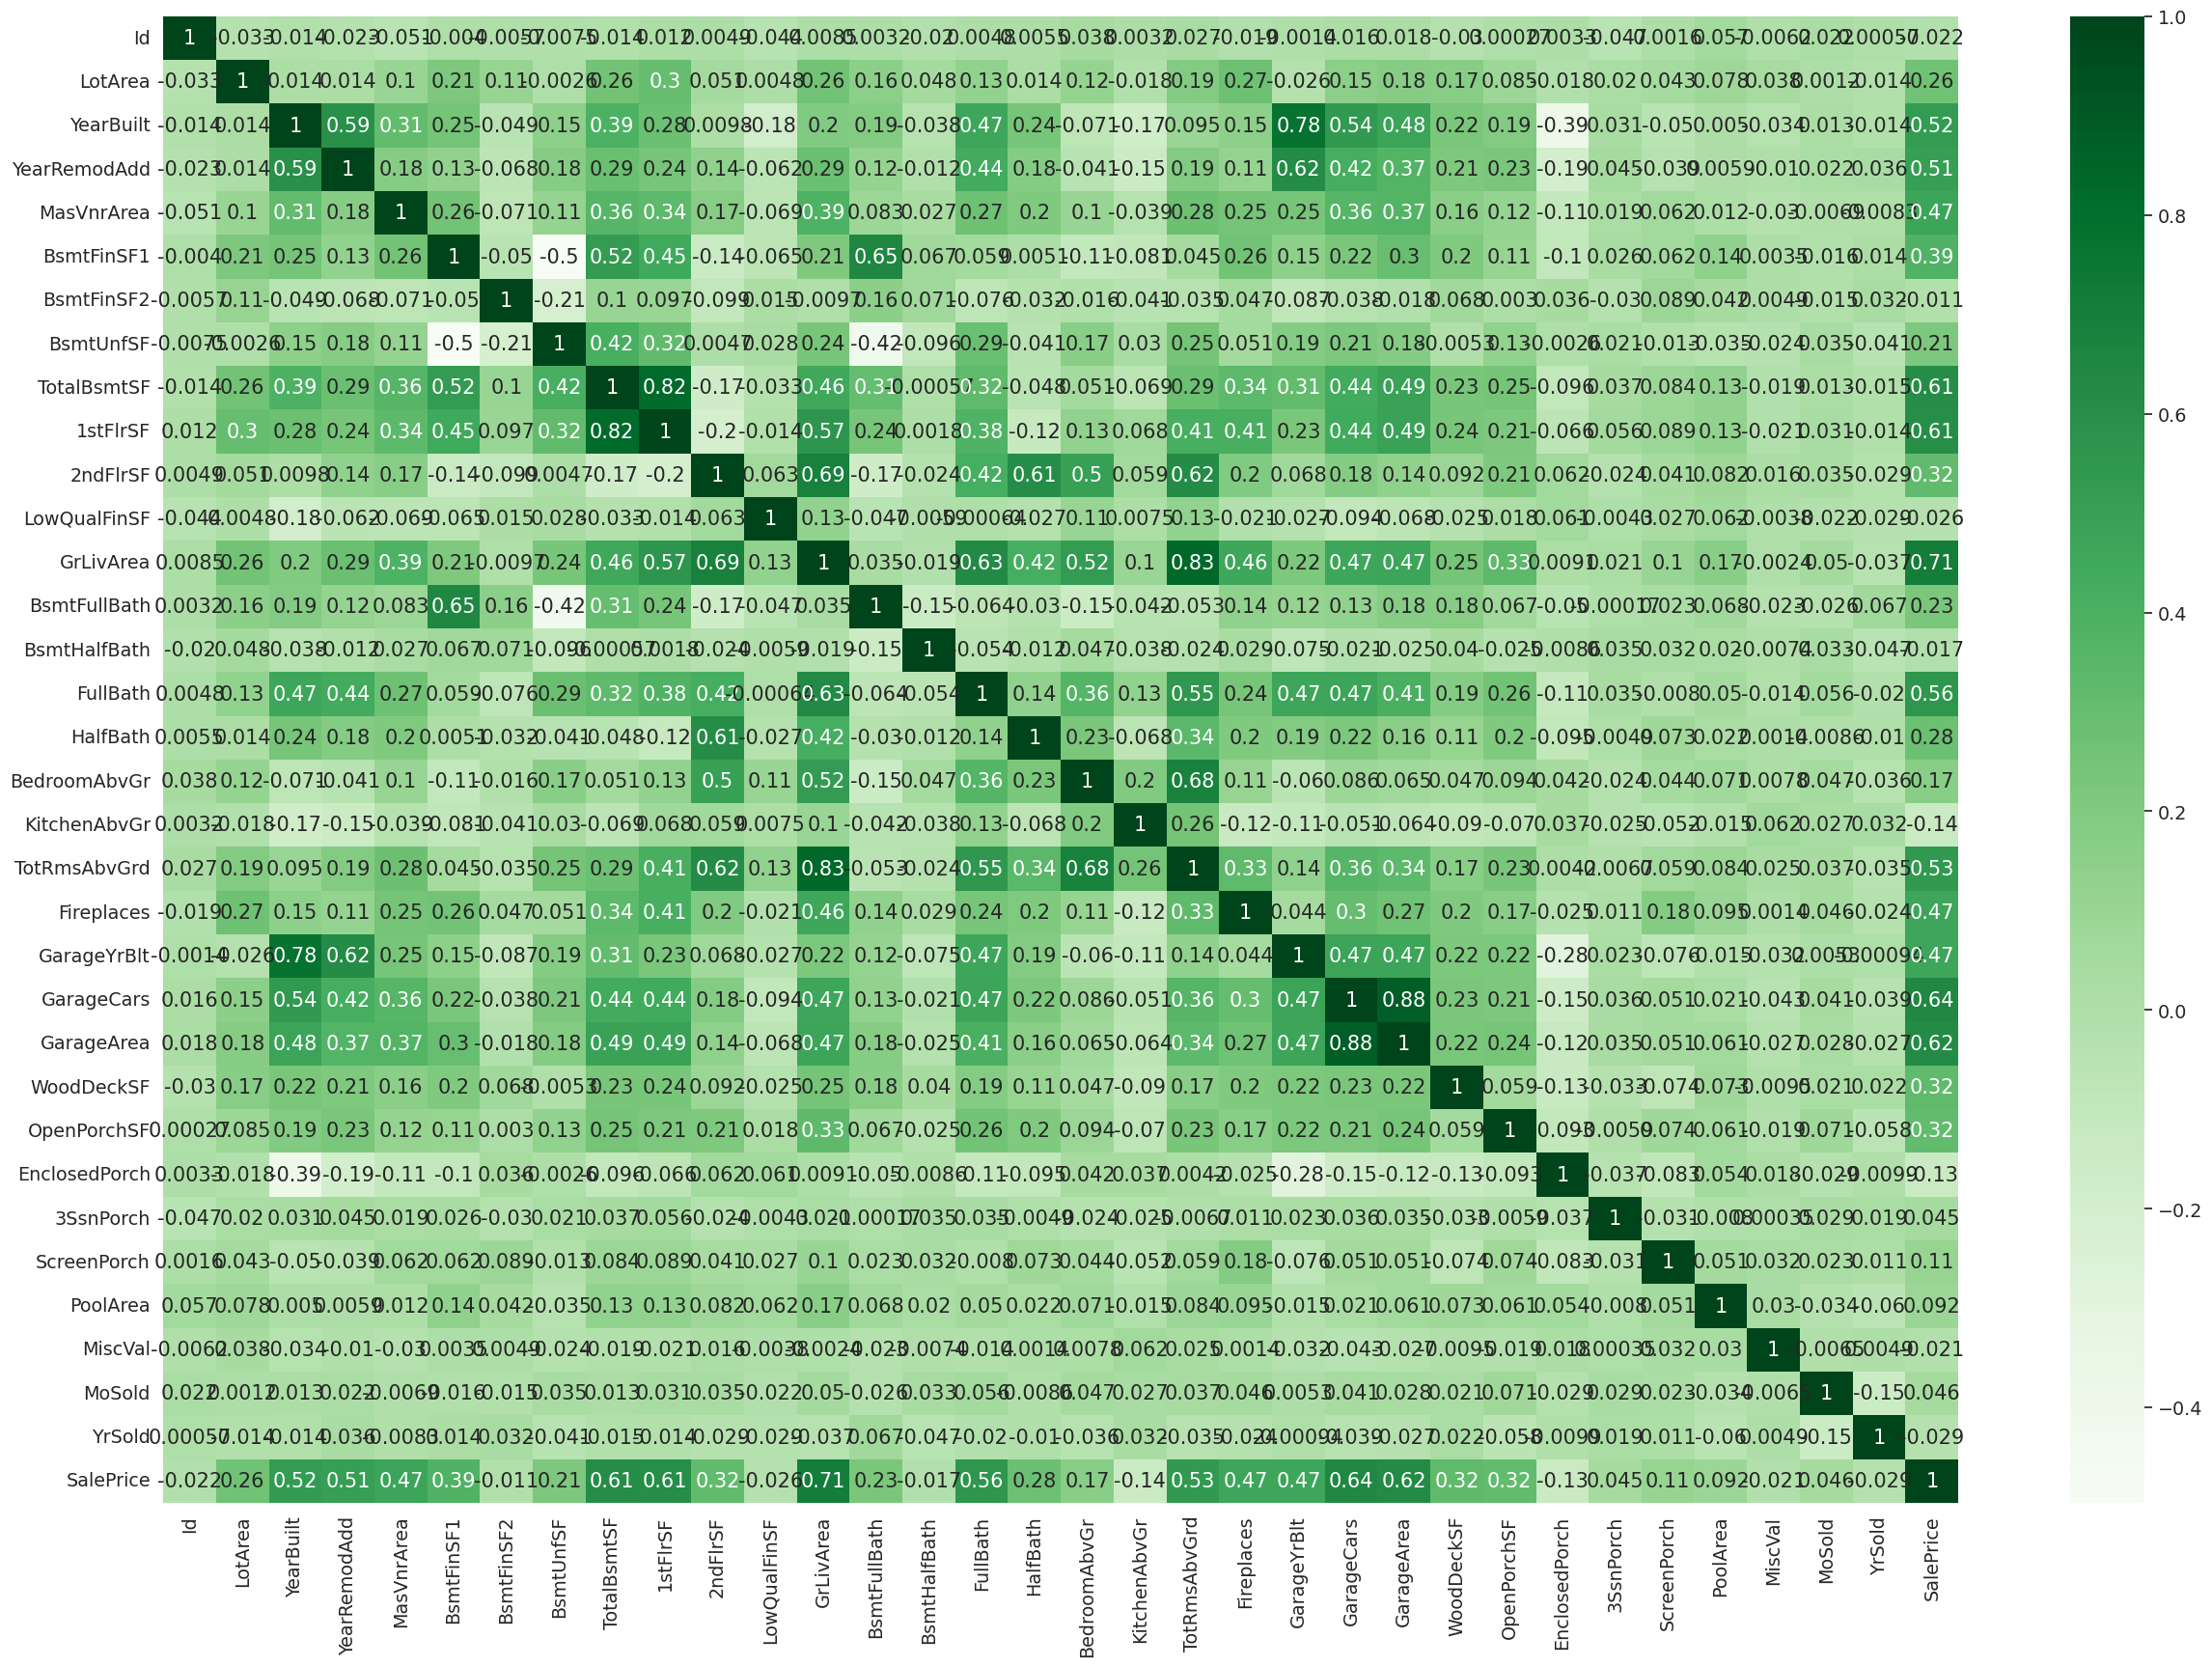

In [77]:
## Bivariate Analysis on Numerical Features

#plotting the correlation matrix
plt.figure(figsize=(30,20))
sns.heatmap(train_data_set[numerical_features_list].corr(), annot=True, cmap="Greens")
plt.show()


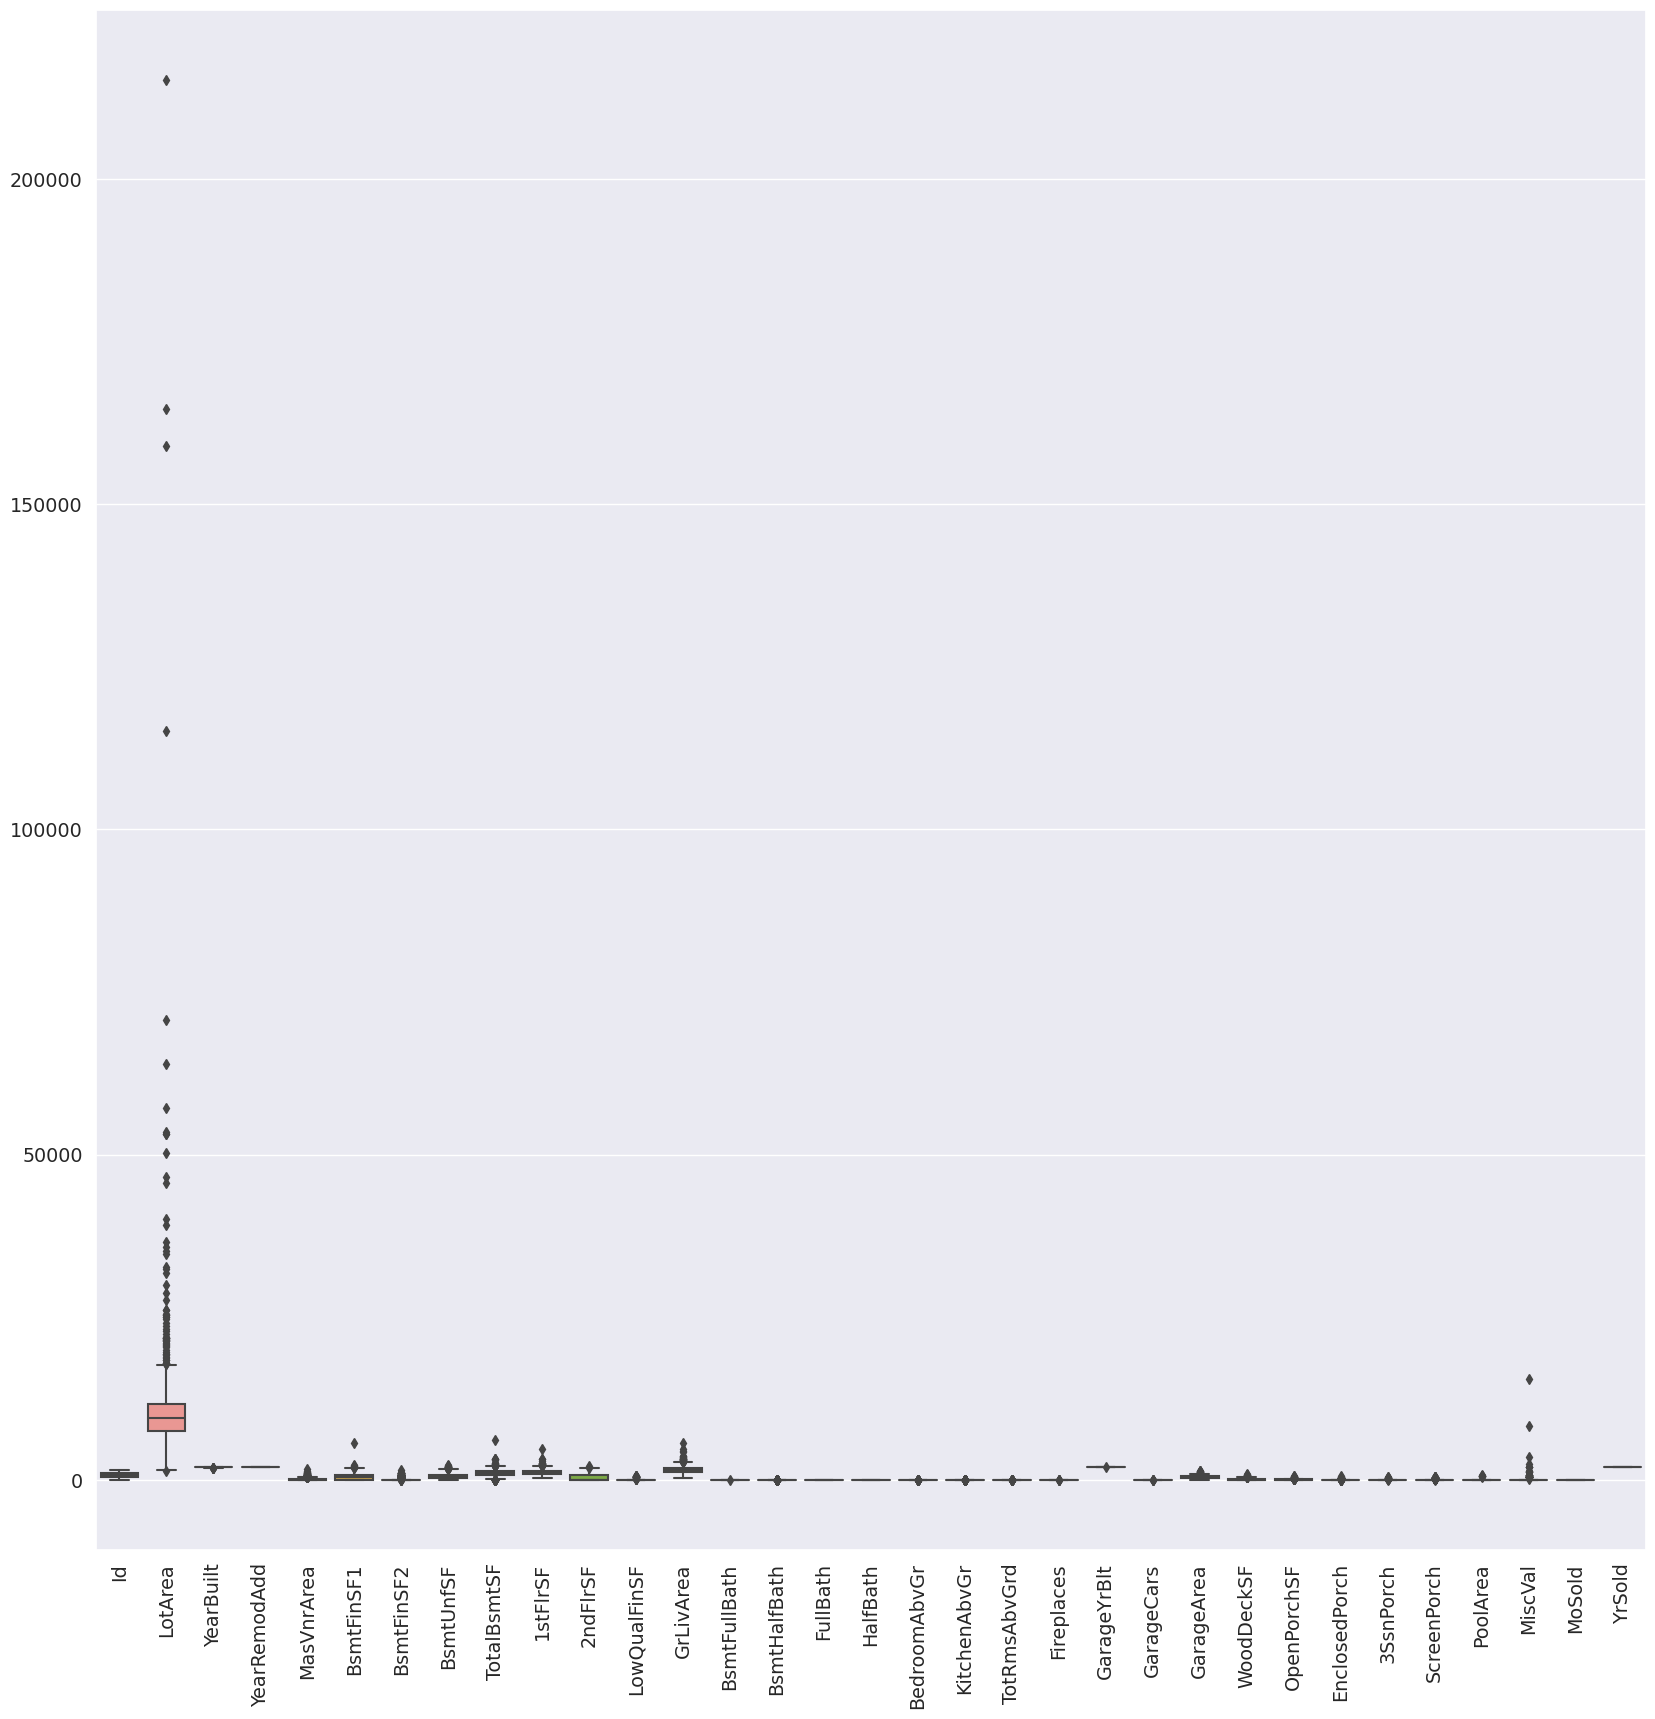

In [79]:
#Outlier Treatment

numerical_features_list_copy = numerical_features_list.copy()
numerical_features_list_copy.remove('SalePrice')

#plotting the boxplot of numerical features expect SalesPrice to check for outliers
plt.figure(figsize=(20,20))
sns.boxplot(data=train_data_set[numerical_features_list_copy])
plt.xticks(rotation=90)
plt.show()

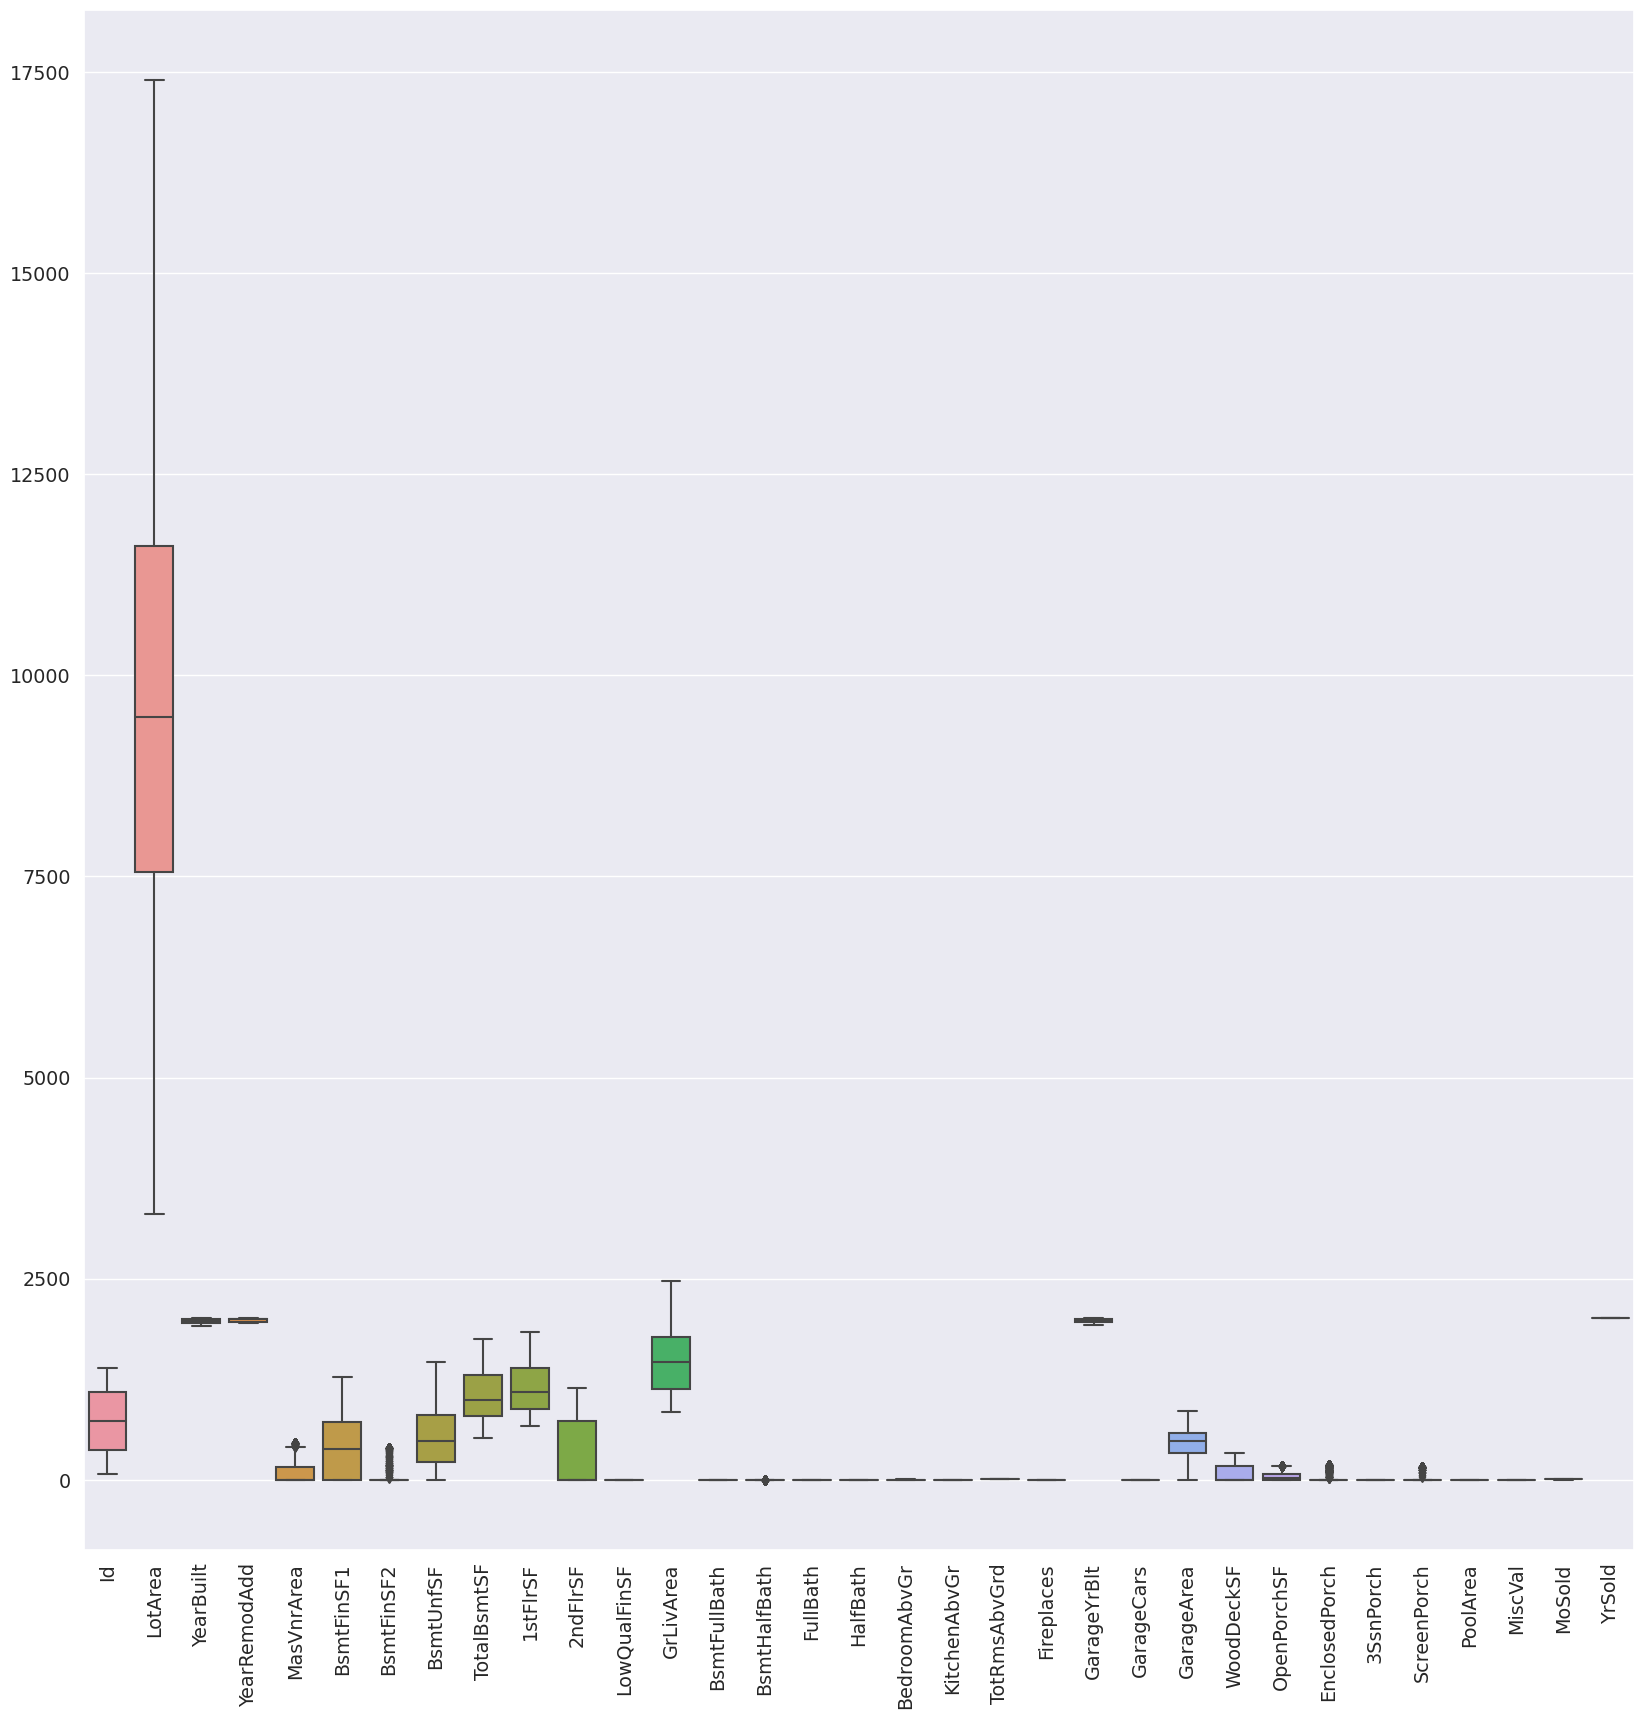

In [80]:
#Restricting the outliers to 5% and 95% quantile
for feature in numerical_features_list_copy:
    train_data_set[feature] = train_data_set[feature].clip(lower=train_data_set[feature].quantile(0.05), upper=train_data_set[feature].quantile(0.95))


#plotting the boxplot of numerical features expect SalesPrice to check for outliers
plt.figure(figsize=(20,20))
sns.boxplot(data=train_data_set[numerical_features_list_copy])
plt.xticks(rotation=90)
plt.show()

In [81]:
# DATA PREP


#One hot encoding the categorical features
train_data_set = pd.get_dummies(train_data_set, columns=categorical_features_list, drop_first=True)

#checking the data after one hot encoding
train_data_set.head()


Id  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
0  73.9   8450.0       2003          2003       196.0         706         0.0   
1  73.9   9600.0       1976          1976         0.0         978         0.0   
2  73.9  11250.0       2001          2002       162.0         486         0.0   
3  73.9   9550.0       1916          1970         0.0         216         0.0   
4  73.9  14260.0       2000          2000       350.0         655         0.0   

   BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  SaleType_ConLI  SaleType_ConLw  \
0        150          856     856.0  ...               0               0   
1        284         1262    1262.0  ...               0               0   
2        434          920     920.0  ...               0               0   
3        540          756     961.0  ...               0               0   
4        490         1145    1145.0  ...               0               0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_AdjLand  \
0             0             0            1                      0   
1             0             0            1                      0   
2             0             0            1                      0   
3             0             0            1                      0   
4             0             0            1                      0   

   SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
0                     0                     0                     1   
1                     0                     0                     1   
2                     0                     0                     1   
3                     0                     0                     0   
4                     0                     0                     1   

   SaleCondition_Partial  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 289 columns]

In [82]:
#scaling the numerical features
scaler = StandardScaler()
train_data_set[numerical_features_list_copy] = scaler.fit_transform(train_data_set[numerical_features_list_copy])


#scaling the numerical features
scaler = StandardScaler()
train_data_set[numerical_features_list_copy] = scaler.fit_transform(train_data_set[numerical_features_list_copy])


Model Building and Evaluation

In [83]:
#Split the data into independent and dependent variables.
X = train_data_set.drop(["Id", "SalePrice", "TransformedPrice"], axis=1)
y = train_data_set["TransformedPrice"]

#Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)



## Create an Unregularized linear regression model.

#Fit the model using the training data.
lr = LinearRegression()
lr.fit(X_train, y_train)

#The R2 score for the training and testing data.
print("Training R2 score: ", lr.score(X_train, y_train))
print("Testing R2 score: ", lr.score(X_test, y_test))

Training R2 score:  0.9483819995171011
Testing R2 score:  -5.061187288789068e+17


In [84]:
## Create an Regularized Linear Regression - Lasso


#Building Lasso regression model
params = {'alpha': np.arange(0.0001, 0.01, 0.001)}
lasso = Lasso()
parameters = params
fold = 5

#Building the grid search model
lasso_regressor = GridSearchCV(estimator=lasso, param_grid=parameters, scoring='neg_mean_absolute_error', cv=fold, verbose=1, return_train_score=True)

#Fit the grid search model to the training data
lasso_regressor.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([0.0001, 0.0011, 0.0021, 0.0031, 0.0041, 0.0051, 0.0061, 0.0071,
       0.0081, 0.0091])},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [85]:
#Checking the results of grid search model
results = pd.DataFrame(lasso_regressor.cv_results_)
results.head().sort_values(by='rank_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
1       0.018588      0.002748         0.004102        0.000362      0.0011   
0       0.111231      0.025826         0.007336        0.001784      0.0001   
2       0.028878      0.011434         0.003684        0.000082      0.0021   
3       0.022431      0.006103         0.008008        0.002576      0.0031   
4       0.011196      0.000716         0.003557        0.000091      0.0041   

              params  split0_test_score  split1_test_score  split2_test_score  \
1  {'alpha': 0.0011}          -0.094709          -0.087347          -0.091878   
0  {'alpha': 0.0001}          -0.108672          -0.087651          -0.098455   
2  {'alpha': 0.0021}          -0.100534          -0.092184          -0.100156   
3  {'alpha': 0.0031}          -0.106729          -0.098483          -0.107229   
4  {'alpha': 0.0041}          -0.109559          -0.103262          -0.111216   

   split3_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
1          -0.088801  ...        -0.089572        0.003377                1   
0          -0.097821  ...        -0.095051        0.009090                2   
2          -0.095540  ...        -0.096154        0.003627                3   
3          -0.099968  ...        -0.101926        0.004219                4   
4          -0.105315  ...        -0.106068        0.003819                5   

   split0_train_score  split1_train_score  split2_train_score  \
1           -0.077350           -0.078820           -0.075802   
0           -0.059654           -0.066176           -0.061738   
2           -0.085827           -0.088481           -0.087396   
3           -0.093013           -0.096965           -0.095504   
4           -0.098415           -0.101887           -0.100672   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
1           -0.078538           -0.079701         -0.078042         0.001349  
0           -0.065014           -0.067229         -0.063962         0.002835  
2           -0.088324           -0.089328         -0.087871         0.001192  
3           -0.095599           -0.096313         -0.095479         0.001342  
4           -0.102063           -0.101640         -0.100935         0.001349  

[5 rows x 21 columns]

In [86]:
#Finding the best parameters
print("Best parameters: ", lasso_regressor.best_params_)

Best parameters:  {'alpha': 0.0011}


In [87]:
#building the lasso model with best parameters
lasso = Lasso(alpha=0.0011)
lasso.fit(X_train, y_train)

#printing the training and testing R2 score
print("Training R2 score: ", lasso.score(X_train, y_train))
print("Testing R2 score: ", lasso.score(X_test, y_test))


Training R2 score:  0.9094898303053927
Testing R2 score:  0.893729926063314


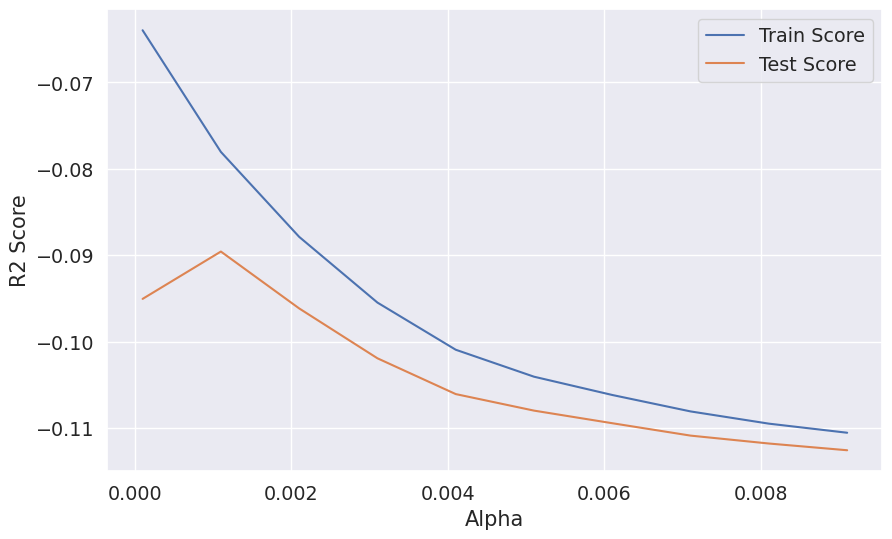

In [88]:
#plotting the R2 score vs alpha values of lasso model
plt.figure(figsize=(10,6))
plt.plot(results['param_alpha'], results['mean_train_score'], label='Train Score')
plt.plot(results['param_alpha'], results['mean_test_score'], label='Test Score')
plt.xlabel('Alpha')
plt.ylabel('R2 Score')
plt.legend()
plt.show()

In [89]:
#Checking the top 10 features of lasso model
lasso_features = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lasso.coef_})
lasso_features.sort_values(by='Coefficient', ascending=False).head(10)

Feature  Coefficient
123         OverallQual_9     0.155713
11              GrLivArea     0.114232
124        OverallQual_10     0.109707
235        Functional_Typ     0.081746
147   Exterior1st_BrkFace     0.080190
278          SaleType_New     0.068556
87   Neighborhood_StoneBr     0.063480
81   Neighborhood_NridgHt     0.062741
71   Neighborhood_Crawfor     0.061600
122         OverallQual_8     0.059924

In [90]:
#To interpret the coefficients of lasso model in terms of target variable, we need to apply inverse log transformation since we applied log transformation to the target variable
lasso_features['Coefficient'] = np.exp(lasso_features['Coefficient'])
lasso_features.sort_values(by='Coefficient', ascending=False).head(10)

Feature  Coefficient
123         OverallQual_9     1.168491
11              GrLivArea     1.121012
124        OverallQual_10     1.115951
235        Functional_Typ     1.085180
147   Exterior1st_BrkFace     1.083493
278          SaleType_New     1.070960
87   Neighborhood_StoneBr     1.065539
81   Neighborhood_NridgHt     1.064751
71   Neighborhood_Crawfor     1.063536
122         OverallQual_8     1.061756

In [91]:
#Regularized Linear Regression - Ridge


#Building Ridge regression model
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]}
ridge = Ridge()

ridge_regressor = GridSearchCV(estimator=ridge, param_grid=params, scoring='r2', cv=5, verbose=1, return_train_score=True)
ridge_regressor.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [92]:
#Checking the results of grid search model
results = pd.DataFrame(ridge_regressor.cv_results_)
results.head().sort_values(by='rank_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
4       0.023714      0.003915         0.005696        0.001705         0.1   
3       0.022034      0.001286         0.007446        0.004201        0.05   
2       0.023910      0.004983         0.006438        0.001245        0.01   
1       0.024344      0.004840         0.005034        0.001126       0.001   
0       0.027106      0.005882         0.005929        0.002680      0.0001   

              params  split0_test_score  split1_test_score  split2_test_score  \
4     {'alpha': 0.1}           0.783660           0.863110           0.734110   
3    {'alpha': 0.05}           0.771815           0.852517           0.718856   
2    {'alpha': 0.01}           0.755932           0.824349           0.695417   
1   {'alpha': 0.001}           0.744606           0.808679           0.685507   
0  {'alpha': 0.0001}           0.742260           0.806669           0.684269   

   split3_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
4           0.845358  ...         0.825483        0.059394               23   
3           0.841619  ...         0.816648        0.063517               25   
2           0.828659  ...         0.799461        0.067722               26   
1           0.820055  ...         0.789778        0.069627               27   
0           0.818875  ...         0.788347        0.069983               28   

   split0_train_score  split1_train_score  split2_train_score  \
4            0.956391            0.950868            0.957845   
3            0.956843            0.952293            0.958655   
2            0.957130            0.953535            0.959367   
1            0.957169            0.953664            0.959455   
0            0.957170            0.953666            0.959456   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
4            0.952766            0.948584          0.953291         0.003425  
3            0.954413            0.950166          0.954474         0.003047  
2            0.956177            0.951734          0.955589         0.002686  
1            0.956414            0.951925          0.955725         0.002652  
0            0.956418            0.951927          0.955727         0.002651  

[5 rows x 21 columns]

In [93]:
#Finding the best parameters
print("Best parameters: ", ridge_regressor.best_params_)

Best parameters:  {'alpha': 10.0}


In [94]:
#building the ridge model with best parameters
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)

#printing the training and testing R2 score
print("Training R2 score: ", ridge.score(X_train, y_train))
print("Testing R2 score: ", ridge.score(X_test, y_test))

Training R2 score:  0.9266642638768539
Testing R2 score:  0.8941285858307557


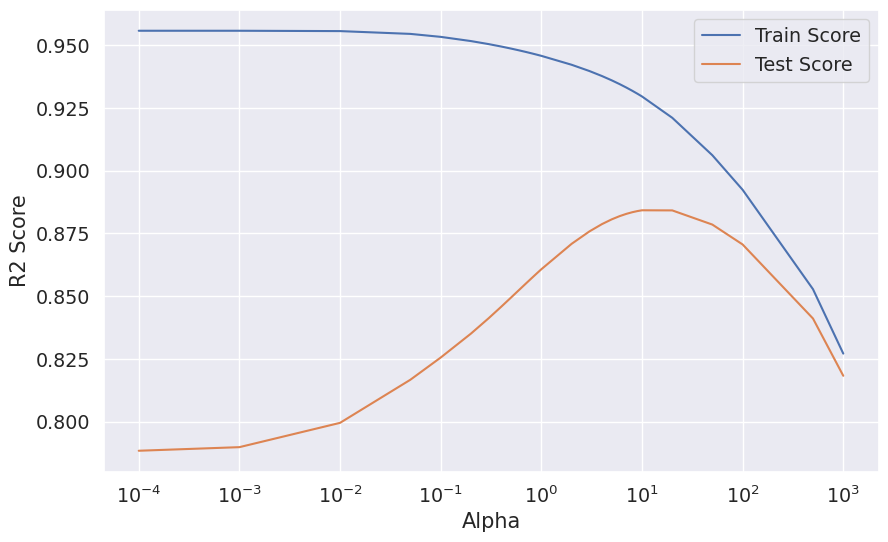

In [95]:
#plotting the R2 score vs alpha values of ridge model
plt.figure(figsize=(10,6))
plt.plot(results['param_alpha'], results['mean_train_score'], label='Train Score')
plt.plot(results['param_alpha'], results['mean_test_score'], label='Test Score')
plt.xlabel('Alpha')
plt.ylabel('R2 Score')
plt.xscale('log')
plt.legend()
plt.show()

In [96]:
#checking the top 10 features of ridge model
ridge_features = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': ridge.coef_})
ridge_features.sort_values(by='Coefficient', ascending=False).head(10)


Feature  Coefficient
123         OverallQual_9     0.096518
87   Neighborhood_StoneBr     0.091528
132         OverallCond_9     0.080452
147   Exterior1st_BrkFace     0.079996
124        OverallQual_10     0.079504
11              GrLivArea     0.076700
81   Neighborhood_NridgHt     0.074047
235        Functional_Typ     0.070609
71   Neighborhood_Crawfor     0.060690
46            MSZoning_FV     0.059740

In [97]:
# To interpret the coefficients of ridge model in terms of target variable, we need to apply inverse log transformation since we applied log transformation to the target variable
ridge_features['Coefficient'] = np.exp(ridge_features['Coefficient'])
ridge_features.sort_values(by='Coefficient', ascending=False).head(10)

Feature  Coefficient
123         OverallQual_9     1.101330
87   Neighborhood_StoneBr     1.095848
132         OverallCond_9     1.083776
147   Exterior1st_BrkFace     1.083283
124        OverallQual_10     1.082749
11              GrLivArea     1.079718
81   Neighborhood_NridgHt     1.076858
235        Functional_Typ     1.073162
71   Neighborhood_Crawfor     1.062570
46            MSZoning_FV     1.061561

**Subjective Questions**

In [98]:

#Question 1 : What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?

#Create a Ridge model with alpha (regularization parameter) set to 20.
ridge = Ridge(alpha=20)

#Train the Ridge model using the training data.
ridge.fit(X_train, y_train)

# Print the R2 score (a measure of model performance) for the training and testing data.
print("Training R2 score: ", ridge.score(X_train, y_train))
print("Testing R2 score: ", ridge.score(X_test, y_test))

# Display the top 10 features and their coefficients in the Ridge model.
ridge_features = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': ridge.coef_})
ridge_features.sort_values(by='Coefficient', ascending=False).head(10)

# Create a Lasso model with alpha set to 0.0022.
lasso = Lasso(alpha=0.0022)

# Train the Lasso model using the training data.
lasso.fit(X_train, y_train)

# Print the R2 score for the training and testing data.
print("Training R2 score: ", lasso.score(X_train, y_train))
print("Testing R2 score: ", lasso.score(X_test, y_test))

# Display the top 10 features and their coefficients in the Lasso model.
lasso_features = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lasso.coef_})
lasso_features.sort_values(by='Coefficient', ascending=False).head(10)


Training R2 score:  0.9195808060202698
Testing R2 score:  0.8929908242719509
Training R2 score:  0.88853133409678
Testing R2 score:  0.8767587842276224


Feature  Coefficient
11              GrLivArea     0.127388
123         OverallQual_9     0.092965
235        Functional_Typ     0.081385
7             TotalBsmtSF     0.063676
222          CentralAir_Y     0.054564
2            YearRemodAdd     0.050917
147   Exterior1st_BrkFace     0.048271
278          SaleType_New     0.042908
1               YearBuilt     0.042187
71   Neighborhood_Crawfor     0.038677

In [99]:
#Question – 3: After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

#Lasso Regression

# Remove the top 5 features from the train and test data in the Lasso model.
X_train_lasso = X_train.drop(['OverallQual_9', 'GrLivArea', 'OverallQual_10', 'Functional_Typ', 'Exterior1st_BrkFace'], axis=1)
X_test_lasso = X_test.drop(['OverallQual_9', 'GrLivArea', 'OverallQual_10', 'Functional_Typ', 'Exterior1st_BrkFace'], axis=1)

# Build the Lasso model with the best parameters.
lasso = Lasso(alpha=0.0011)
lasso.fit(X_train_lasso, y_train)

# Calculate and print the training R2 score.
print("Training R2 score: ", lasso.score(X_train_lasso, y_train))

# Calculate and print the testing R2 score.
print("Testing R2 score: ", lasso.score(X_test_lasso, y_test))


Training R2 score:  0.9027214948908173
Testing R2 score:  0.889227555103999


In [100]:
#checking the top 5 features of lasso model
lasso_features = pd.DataFrame({'Feature': X_train_lasso.columns, 'Coefficient': lasso.coef_})
lasso_features.sort_values(by='Coefficient', ascending=False).head(5)

Feature  Coefficient
86  Neighborhood_StoneBr     0.106699
80  Neighborhood_NridgHt     0.097511
9               2ndFlrSF     0.090733
7            TotalBsmtSF     0.066868
8               1stFlrSF     0.065647

In [101]:
#Ridge Regression
#removing the top 5 features of ridge model from train and test data
X_train_ridge = X_train.drop(['OverallQual_9', 'Neighborhood_StoneBr', 'OverallCond_9', 'Exterior1st_BrkFace', 'OverallQual_10'], axis=1)
X_test_ridge = X_test.drop(['OverallQual_9', 'Neighborhood_StoneBr', 'OverallCond_9', 'Exterior1st_BrkFace', 'OverallQual_10'], axis=1)

#building the ridge model with best parameters
ridge = Ridge(alpha=10)
ridge.fit(X_train_ridge, y_train)

#printing the training and testing R2 score
print("Training R2 score: ", ridge.score(X_train_ridge, y_train))
print("Testing R2 score: ", ridge.score(X_test_ridge, y_test))

Training R2 score:  0.9214128826901359
Testing R2 score:  0.8906274265164016


In [102]:
#checking the top 5 features of ridge model
ridge_features = pd.DataFrame({'Feature': X_train_ridge.columns, 'Coefficient': ridge.coef_})
ridge_features.sort_values(by='Coefficient', ascending=False).head(5)

Feature  Coefficient
11              GrLivArea     0.076809
230        Functional_Typ     0.074510
81   Neighborhood_NridgHt     0.070010
46            MSZoning_FV     0.059327
56        LandContour_HLS     0.059224